In [325]:
from datetime import datetime
import numpy as np
from scipy import special
from scipy.integrate import cumtrapz
from plasmapy.dispersion.dispersionfunction import plasma_dispersion_func
from scipy.interpolate import interp1d as interp
from scipy.interpolate import RectBivariateSpline as RBS
import matplotlib.pyplot as plt
import multiprocessing as mp
from functools import partial



class electronHole():
    
    def __init__(self, height=0.7, width=4.0, vpl=1.0, hole_region_over_width=6):
        self.height = height
        self.width = width
        self.vpl = vpl # thermal parallel velocity of Maxwellian distribution
        self.hole_region = width * hole_region_over_width # when abs(z)>hole_region, the effects of electron hole are neglected
    
    def sech(self, z): 
        #self-defined 'sech' function
        #since numpy doesn't have the 'sech' function and using np.cosh() leads to overflow when z is large
        z = np.asarray(z)
        res = np.zeros_like(z)
        res[np.abs(z)<100] = 1 / np.cosh(z[np.abs(z)<100])
        return res
        
    #electro potential as a function of position z
    def potential(self, z):
        return self.height * (self.sech(z/self.width))**4
    
    #the first derivative of potential w.r.t. z, the same as MD4 except the coefficient
    def dpdz(self, z):
        return -4*self.height/self.width * np.tanh(z/self.width) * (self.sech(z/self.width))**4
    
    #MDi, i=1,2,3,4,5 are 5 discrete eigenmodes of the differential equation neglecting J operator
    #all of them are normalized
    def MD1(self, z): #symmetric
        s = self.sech(z/self.width)
        return np.sqrt(30/self.width)/16 * (8*s-28*s**3+21*s**5)
    
    def MD2(self, z):#anti-symmetric
        s = self.sech(z/self.width)
        return np.sqrt(105/self.width)/4 * (2*s**2-3*s**4)*np.tanh(z/self.width)
    
    def MD3(self, z):#symmetric
        s = self.sech(z/self.width)
        return np.sqrt(105/self.width)/16 * (8*s**3-9*s**5)
    
    def MD4(self, z):#anti-symmetric, also called shiftmode
        return 3*np.sqrt(70/self.width)/8 * np.tanh(z/self.width) * (self.sech(z/self.width))**4
       
    def MD5(self, z):#symmetric
        return np.sqrt(35/self.width)*3/16 * self.sech(z/self.width)**5
    
    #MCk are normalized continuous eigenmodes, where k indicates the wavenumber of the mode in the region far away from the electron hole
    def MCAk(self, k, z):#anti-symmetric
        x = z/self.width
        s = self.sech(x)
        P = -15 * np.tanh(x) * (k**4 + (28*s**2-15)*k**2 + (63*s**4-56*s**2+8))
        Q = k**4 + (105*s**2-85)*k**2 + (945*s**4-1155*s**2+274)
        #return (P+1j*k*Q) * np.exp(1j*k*x) / np.sqrt(2*np.pi) / np.sqrt(k**2+1) / np.sqrt(k**2+4) / np.sqrt(k**2+9) / np.sqrt(k**2+16) / np.sqrt(k**2+25)
        return (P+1j*k*Q*np.sign(x)) * np.exp(1j*k*np.abs(x)) / np.sqrt(2*np.pi*self.width) / np.sqrt(k**2+1) / np.sqrt(k**2+4) / np.sqrt(k**2+9) / np.sqrt(k**2+16) / np.sqrt(k**2+25)
    
    
    def MCSk(self, k, z):#symmetric continuous mode
        return np.sign(x) * self.MCAk(k, z)
    
    def gamma(self, omega, kp, kn):
        
        kn = np.asarray(kn)
        res = np.ones_like(kn, dtype=np.complex_) * kp**2
        b = (kn!=0)
        res[b] = kp**2 + 1+kn[b]**2 + omega/np.sqrt(2)/kn[b]*plasma_dispersion_func(omega/np.sqrt(2)/kn[b])
        return res
        
    #MC is the effective continuous mode that has coupling with shiftmode
    #It's calculated by integrating some combination of MCAk functions over wavenumber k
    def MC(self, z0, z, omega, kp, kin=100, kperiod=(100,400), knum=(100, 1000, 2000)):

        kstep = 2*np.pi/abs(abs(z0)-abs(z)) if abs(z0)!=abs(z) else 10
        kin = kp * self.width * np.abs(omega) * kin
        k = np.hstack([np.linspace(-kin-kstep*kperiod[1], -kin-kstep*kperiod[0], num=knum[0]+1),
                       np.linspace(-kin-kstep*kperiod[0], -kin, num=knum[1]+1),
                       np.linspace(-kin, kin, num=knum[2]+1),
                       np.linspace(kin, kin+kstep*kperiod[0], num=knum[1]+1),
                       np.linspace(kin+kstep*kperiod[0], kin+kstep*kperiod[1], num=knum[0]+1)
                      ])
        intgd = self.MCAk(k, z0)*self.MCAk(-k, z) / self.gamma(omega, kp, k/self.width)
        return np.trapz(intgd, k)
        
    
    def distribution(self, w): # as a function of the total energy w of electrons
        
        w = np.array(w, dtype=np.float64)
        f = np.zeros_like(w)

        #distribution for passing electrons
        ind_pos = w>=0
        f[ind_pos] = 1 / np.sqrt(2*np.pi) / self.vpl * np.exp(-w[ind_pos]/self.vpl**2)

        #distribution for trapped electrons
        ind_neg = w<0
        f[ind_neg] =  16 * np.sqrt(-2*w[ind_neg]) / np.pi/self.width**2 \
                    + 15 * w[ind_neg] / self.width**2 / np.sqrt(2*self.height) \
                    + 1/np.sqrt(2*np.pi)/self.vpl * np.exp(-w[ind_neg]/self.vpl**2) * special.erfc(np.sqrt(-w[ind_neg])/self.vpl)
        return f
    
    
    def dfdw(self, w): #the derivative of distribution w.r.t. w
        
        w = np.array(w, dtype=np.float64)
        g = np.zeros_like(w)

        #dfdw for passing particles
        ind_pos = (w>=-1e-9)
        g[ind_pos] = -1 / np.sqrt(2*np.pi) / self.vpl**3 * np.exp(-w[ind_pos]/self.vpl**2)
        
        #dfdw for trapped particles
        ind_neg = (w<-1e-9)
        g[ind_neg] = (1/self.vpl**2 - 16/self.width**2)/np.pi/np.sqrt(-2*w[ind_neg]) + \
                     15 / self.width**2 / np.sqrt(2*self.height) - \
                     1/np.sqrt(2*np.pi)/(self.vpl**3) * np.exp(-w[ind_neg]/self.vpl**2) * special.erfc(np.sqrt(-w[ind_neg])/self.vpl)
        return g

    

        #Calculation of the table of tau(z,w) for passing particles(w>0).
    def tau_map_passing(self, lgwmin=-6, lgwmax=2, wnum=1000, znum=1000, tnum=1000):
        #tau is the time elapsed for the passing particles to arrive at position z>0 from position 0. 
        #No need to worry about the case z<0 due to symmetry.
        #We can simply look up this pre-calculated table to find out the time required to travel between any two positions z0 --> z. 
        #It's better to store log(tau+1) since tau-->infty as z-->infty.
    
        #Discretization of w(>0)
        
        lgwarray = np.linspace(lgwmin, lgwmax, num=int(wnum)+1)
        warray = self.height * 10**(lgwarray)
        zarray = np.linspace(-self.hole_region, self.hole_region, num=int(znum)+1)
        #The grid points in [w,z] space, note that tau is a function of w and z
        wmesh, zmesh = np.meshgrid(warray, zarray)
        
        #The integrand: 1/vz
        vzinv = 1 / np.sqrt(2*(wmesh+self.potential(zmesh)))
        tau = cumtrapz(vzinv, zmesh, initial=0, axis=0)
        lgT_interp = interp(lgwarray, np.log10(tau[-1, :]))
        tau_norm = tau / tau[-1:, :]
        tauq = np.linspace(0, 1, num=int(tnum)+1)

        zq = np.array([np.interp(tauq, tau_norm[:, i], zarray) for i in range(len(lgwarray))]).T #(Nt, Nw)

        z_spline = RBS(tauq, lgwarray, zq, kx=1, ky=1)

        return lgT_interp, z_spline
    
    
    def energy_integral_passing(self, omega, lgT_interp, z_spline, funcX=None, kX=None, funcY=None, kY=None, lgwmin=-6, lgwmax=2, wnum=100, tnum=100, steps_per_period=100):
        
        lgwarray = np.linspace(lgwmin, lgwmax, num=int(wnum)+1)
        warray = self.height * 10**(lgwarray)   
        T = 10**(lgT_interp(lgwarray))
        tstep = max(2*np.pi/np.abs(np.real(omega))/steps_per_period, np.pi/5)
        
        #resonances Tq=(k+1/2)*np.pi/omega
        t_norm = np.linspace(0, 1, num=int(max(T)/tstep)) #**3 #shape:(Nt, )
        z = z_spline.__call__(t_norm, lgwarray)  #shape:(Nt, Nw)
        
        if funcX is None:
            fX = self.MD4(z) #shape:(Nt, Nw)
        elif funcX=='MCAk':
            fX = self.MCAk(-kX,z)
        else:
            fX = eval(f'{funcX}(z)')
            
        if funcY is None:
            fY = self.MD4(z) #shape:(Nt, Nw)
        elif funcY=='MCAk':
            fY = self.MCAk(kY,z)
        else:
            fY = eval(f'{funcY}(z)')
            
        t = np.dot(t_norm.reshape(-1,1), T.reshape(1,-1)) #shape:(Nt, Nw)
        tr = T.reshape(1,-1) - t
        Xp = cumtrapz(fX*np.exp(1j*omega*t), x=t, initial=0, axis=0) #shape:(Nt, Nw)
        Xn = cumtrapz(fX*np.exp(1j*omega*tr), x=t, initial=0, axis=0) #shape:(Nt, Nw)
        Yp = cumtrapz(fY*np.exp(1j*omega*t), x=t, initial=0, axis=0) #shape:(Nt, Nw)
        Yn = cumtrapz(fY*np.exp(1j*omega*tr), x=t, initial=0, axis=0) #shape:(Nt, Nw)
        
        Xm = np.zeros_like(t, dtype=np.complex_)
        Ym = np.zeros_like(t, dtype=np.complex_)
        for i in range(1,t.shape[0]):
            dti = t[i,:]-t[i-1,:]
            expdti = np.exp(1j*omega*dti)
            Xm[i,:] = Xm[i-1,:]*expdti + (fX[i-1,:]*expdti+fX[i,:])/2 * dti
            Ym[i,:] = Ym[i-1,:]*expdti + (fY[i-1,:]*expdti+fY[i,:])/2 * dti
            
        intgd = np.trapz(fX*Ym+fY*Xm, x=t, axis=0)
            
        if funcY=='MCAk':
            intgd += -1j*self.MCAk(kY, self.hole_region)/(omega+kY/self.width*np.sqrt(2*warray)) * (Xp[-1,:]-Xn[-1,:])
            
        if funcX=='MCAk':
            intgd += -1j*self.MCAk(-kX, self.hole_region)/(omega-kX/self.width*np.sqrt(2*warray)) * (Yp[-1,:]-Yn[-1,:])
            
        if funcX=='MCAk' and funcY=='MCAk':
            intgd += 2*np.exp(1j*omega*T)*self.MCAk(-kX, self.hole_region)*self.MCAk(kY,self.hole_region)/(omega-kX/self.width*np.sqrt(2*warray))/(omega+kY/self.width*np.sqrt(2*warray))
            zp = np.linspace(0, self.hole_region, num=1000)
            Iz = np.trapz(self.MCAk(-kX, zp)*self.MCAk(kY, zp), x=zp)
            intgd += -2j* Iz / np.sqrt(2*warray) * (1/(omega+kX/self.width*np.sqrt(2*warray)) + 1/(omega-kY/self.width*np.sqrt(2*warray)))
            intgd += 2 / (omega-kX/self.width*np.sqrt(2*warray)) / (omega-kY/self.width*np.sqrt(2*warray)) * self.MCAk(-kX,self.hole_region) * self.MCAk(kY,self.hole_region)
            
        if funcX=='np.sign' and funcY=='np.sign':
            intgd += -1j / omega * (Yp[-1,:]-Yn[-1,:])
            intgd += -1j / omega * (Xp[-1,:]-Xn[-1,:])
            intgd += 2 * np.exp(1j*omega*T) / omega**2
            intgd += -4j * self.hole_region / np.sqrt(2*warray) / omega
            intgd += 2 / omega**2
            
        return 1j*omega*np.trapz(intgd, self.distribution(warray)) #, intgd, warray
            
    

    
    #dtau=dz/vz=dz/sqrt(2*(Psi*S(z/4)^4+W)) is not integratable, so we need to create a mapping between tau and (W, z).
    #the output are 1. an interpolant tau(W, z) which tells you the value of tau for any pair of W and z through intepolation;
    #2. the inverse interpolant z(W, tau);
    #3. the interpolant for quaterly period Tq(W).
    #The variables are transformed somehow to get better linearity. For example, since Tq ~ 1/sqrt(|W|), we know log(Tq) ~ log(|W|)
    #the interpolant for Tq is actually log(Tq)(log(|W|)).
    def tau_map_trapped(self, wnum=200, tnum=1e4, znum=1e5, lgwmin=-10, frac=0.3):

        wmin, wmax = -self.height * (1-10**(lgwmin)), -self.height * 10**(lgwmin) #-self.potential(self.hole_region)

        warray = wmax - (wmax-wmin) * np.logspace(0, lgwmin, num=int(wnum)+1) #warray = np.linspace(wmin, wmax, num=wnum+1)
        
        lgw = -np.log10(-warray/self.height)

        zmax = np.arccosh((-warray/self.height)**(-1/4)) * self.width

        z_norm = np.linspace(0, 1, num=int(znum)+1)

        Nmid = int(len(z_norm)*frac)

        zmesh = np.dot(z_norm[:Nmid].reshape(-1,1), zmax.reshape(1,-1))

        wmesh = np.dot(np.ones((Nmid,1)), warray.reshape(1,-1))

        #The inverse of vz which is the integrand of tau-integral
        vzinv = 1 / np.sqrt(2*(wmesh+self.potential(zmesh)))

        #Find out tau(z,w)
        tau1 = cumtrapz(vzinv, zmesh, initial=0, axis=0)

        zmesh = np.dot(z_norm[Nmid:].reshape(-1,1), zmax.reshape(1,-1))

        wmesh = np.dot(np.ones((len(z_norm)-Nmid,1)), warray.reshape(1,-1))

        #The inverse of vz which is the integrand of tau-integral
        vz = np.sqrt(2*(wmesh+self.potential(zmesh)))
        
        vz[-1, :] = 0

        tau2 = cumtrapz(1/self.dpdz(zmesh), vz, initial=0, axis=0)

        tau2 = tau2 + tau1[-1, :]

        tau = np.vstack([tau1, tau2])
    
        #Quarter period of each orbit with energy w<0
        Tq = tau[-1,:]
        
        lgT_interp = interp(lgw, np.log10(Tq))
        
        lgw_interp = interp(np.log10(Tq), lgw)

        tau_norm = tau / Tq
        
        tau_res = tau_norm**(1/2/lgw.reshape(1,-1))
        
        tau_spline = RBS(z_norm, lgw, tau_res, kx=1, ky=1)
        
        tauq = np.linspace(0, 1, num=int(tnum)+1)

        zq_res = np.array([np.interp(tauq, tau_norm[:, i], z_norm**(2*lgw[i])) for i in range(len(lgw))]).T

        z_spline = RBS(tauq, lgw, zq_res, kx=1, ky=1)

        return lgT_interp, lgw_interp, z_spline, tau_spline
        
 
    def energy_integral_trapped(self, omega, lgT_interp, lgw_interp, z_spline, funcX=None, kX=None, funcY=None, kY=None, wnum=100, lgwmin=-6, num_res=3, steps_per_period=100):
        
        Tqmin = 10**lgT_interp(-np.log10(1-10**(lgwmin)))
        
        Tqmin = Tqmin * 2 * np.real(omega) / np.pi
        
        dTq = (1-Tqmin) / wnum
        
        #linear spacing in phase for appropriate resonance integral
        Tq = np.arange(Tqmin, num_res*2, dTq) * np.pi / 2 / np.real(omega)
        
        lgw = lgw_interp(np.log10(Tq))
        
        warray = - self.height * 10**(-lgw)
        
#         print(warray[0]/self.height, warray[-1]/self.height)
#         plt.loglog(-warray/self.height, Tq)
#         plt.grid()
#         plt.show()
        
        zmax = np.arccosh((-warray/self.height)**(-1/4)) * self.width #shape:(Nw, )
        
        tstep = max(2*np.pi/np.abs(np.real(omega))/steps_per_period, np.pi/5)
        
        t_norm = np.linspace(0, 1, num=int(max(Tq)/tstep)) #**3 #shape:(Nt, )
        
        z = z_spline.__call__(t_norm, lgw) ** (1/2/lgw.reshape(1,-1)) * zmax.reshape(1,-1)  #shape:(Nt, Nw)
        
        if funcX is None:
            fX = self.MD4(z) #shape:(Nt, Nw)
        elif funcX=='MCAk':
            fX = self.MCAk(-kX,z)
        else:
            fX = eval(f'{funcX}(z)')
            
        if funcY is None:
            fY = self.MD4(z) #shape:(Nt, Nw)
        elif funcY=='MCAk':
            fY = self.MCAk(kY,z)
        else:
            fY = eval(f'{funcY}(z)')
            
        t = np.dot(t_norm.reshape(-1,1), Tq.reshape(1,-1)) #shape:(Nt, Nw)
        tr = Tq.reshape(1,-1) - t
        
        Xp = cumtrapz(fX*np.exp(1j*omega*t), x=t, initial=0, axis=0) #shape:(Nt, Nw)
        Xn = cumtrapz(fX*np.exp(1j*omega*tr), x=t, initial=0, axis=0) #shape:(Nt, Nw)
        Yp = cumtrapz(fY*np.exp(1j*omega*t), x=t, initial=0, axis=0) #shape:(Nt, Nw)
        Yn = cumtrapz(fY*np.exp(1j*omega*tr), x=t, initial=0, axis=0) #shape:(Nt, Nw)
        
        Xm = np.zeros_like(t, dtype=np.complex_)
        Ym = np.zeros_like(t, dtype=np.complex_)
        for i in range(1,t.shape[0]):
            dti = t[i,:]-t[i-1,:]
            expdti = np.exp(1j*omega*dti)
            Xm[i,:] = Xm[i-1,:]*expdti + (fX[i-1,:]*expdti+fX[i,:])/2 * dti
            Ym[i,:] = Ym[i-1,:]*expdti + (fY[i-1,:]*expdti+fY[i,:])/2 * dti
                   
        intgd = (Xn[-1,:]*Yn[-1,:] - Xp[-1,:]*Yp[-1,:] - (Xp[-1,:]*Yn[-1,:]+Yp[-1,:]*Xn[-1,:]) * np.exp(1j*omega*Tq)) / (1+np.exp(1j*omega*2*Tq)) + np.trapz(fX*Ym+fY*Xm, x=t, axis=0)
                #+ (np.trapz(Xn, x=Yp, axis=0)+np.trapz(Yn, x=Xp, axis=0)) * np.exp(-1j*omega*Tq)
        
        return 2*1j*omega*np.trapz(intgd, self.distribution(warray)) #, -warray/self.height, Tq
    
    
    
#     def eigenvalue(self, omega, parallel=False):
   
#         Ip44 = self.energy_integral_passing(omega, lgwmin=-6, lgwmax=3, wnum=400, tnum=500, steps_per_period=100)
#         It44 = self.energy_integral_trapped(omega, wnum=400, lgwmin=-7, tnum=2000)

# #         ncpu = mp.cpu_count()
# #         #print(f'connected to {ncpu} CPUs')
# #         pool_obj = mp.Pool(ncpu)
# #         Jp4 = partial(self.orbit_integral_passing_discrete, omega=omega, tau_spline_passing=tau_spline_passing, 
# #                      warray=warray_passing, func=None, wnum=600, lgvzmin=-15, znum=200)
# #         kp = np.sqrt(np.trapz(self.dpdz(z0)*J4, z0) / np.trapz(self.dpdz(z0)**2, z0))
        
#         return Ip44+It44
    
    
    def growth_rate_shiftmode(self, wr, lgT_interp_passing, z_spline_passing, lgT_interp_trapped, lgw_interp_trapped, z_spline_trapped, wi_low=1e-5, wi_high=1e-2, accuracy_tor=1e-5, parallel=False):

        kp = self.energy_integral_passing(wr+1j*wi_low, lgT_interp_passing, z_spline_passing, lgwmin=-6, lgwmax=3, wnum=400, tnum=500, steps_per_period=20)
        
        kp += self.energy_integral_trapped(wr+1j*wi_low, lgT_interp_trapped, lgw_interp_trapped, z_spline_trapped, wnum=400)

        kp_low = np.imag(kp)

        kp = self.energy_integral_passing(wr+1j*wi_high, lgT_interp_passing, z_spline_passing, lgwmin=-6, lgwmax=3, wnum=400, tnum=500, steps_per_period=20)
        kp += self.energy_integral_trapped(wr+1j*wi_high, lgT_interp_trapped, lgw_interp_trapped, z_spline_trapped, wnum=400)

        kp_high = np.imag(kp)

        if kp_low*kp_high<0:

            while True:

                wi_mid = (wi_low+wi_high)/2
                
                kp = self.energy_integral_passing(wr+1j*wi_mid, lgT_interp_passing, z_spline_passing, lgwmin=-6, lgwmax=3, wnum=400, tnum=500, steps_per_period=20)
                kp += self.energy_integral_trapped(wr+1j*wi_mid, lgT_interp_trapped, lgw_interp_trapped, z_spline_trapped, wnum=400)

                kp_mid = np.imag(kp)
                print(kp_mid)

                if abs(kp_mid) < accuracy_tor:
                    break

                elif kp_mid*kp_low>0:
                    wi_low = wi_mid

                else:
                    wi_high = wi_mid
            
            print(wr, wi_mid, np.real(kp))
            
            return wi_mid, np.real(kp)
        
        print(wr, np.nan, np.nan)
        
        return np.nan, np.nan
    
    
    
    
    def multimode_matrix(self, kp, omega, lgT_interp_passing, z_spline_passing, lgT_interp_trapped, lgw_interp_trapped, z_spline_trapped, wnum=[100,100], spp=[10,100], num_res=3):
        
        q0 = np.real(omega) * kp * self.width

        I44 = self.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='self.MD4', funcY='self.MD4', steps_per_period=spp[0], wnum=wnum[0])
        I22 = self.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='self.MD2', funcY='self.MD2', steps_per_period=spp[0], wnum=wnum[0])
        Iqq = self.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='MCAk', kX=q0, funcY='MCAk', kY=q0, steps_per_period=spp[0], wnum=wnum[0])
        I42 = self.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='self.MD4', funcY='self.MD2', steps_per_period=spp[0], wnum=wnum[0])
        I24 = self.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='self.MD2', funcY='self.MD4', steps_per_period=spp[0], wnum=wnum[0])
        I2q = self.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='self.MD2', funcY='MCAk', kY=q0, steps_per_period=spp[0], wnum=wnum[0])
        Iq2 = self.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='MCAk', kX=q0, funcY='self.MD2', steps_per_period=spp[0], wnum=wnum[0])
        I4q = self.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='self.MD4', funcY='MCAk', kY=q0, steps_per_period=spp[0], wnum=wnum[0])
        Iq4 = self.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='MCAk', kX=q0, funcY='self.MD4', steps_per_period=spp[0], wnum=wnum[0])
        
        I44 += self.energy_integral_trapped(omega, lgT_interp_trapped, lgw_interp_trapped, z_spline_trapped, funcX='self.MD4', funcY='self.MD4', steps_per_period=spp[1], wnum=wnum[1], num_res=num_res)
        I22 += self.energy_integral_trapped(omega, lgT_interp_trapped, lgw_interp_trapped, z_spline_trapped, funcX='self.MD2', funcY='self.MD2', steps_per_period=spp[1], wnum=wnum[1], num_res=num_res)
        Iqq += self.energy_integral_trapped(omega, lgT_interp_trapped, lgw_interp_trapped, z_spline_trapped, funcX='MCAk', kX=q0, funcY='MCAk', kY=q0, steps_per_period=spp[1], wnum=wnum[1], num_res=num_res)
        I42 += self.energy_integral_trapped(omega, lgT_interp_trapped, lgw_interp_trapped, z_spline_trapped, funcX='self.MD4', funcY='self.MD2', steps_per_period=spp[1], wnum=wnum[1], num_res=num_res)
        I24 += self.energy_integral_trapped(omega, lgT_interp_trapped, lgw_interp_trapped, z_spline_trapped, funcX='self.MD2', funcY='self.MD4', steps_per_period=spp[1], wnum=wnum[1], num_res=num_res)
        Iq4 += self.energy_integral_trapped(omega, lgT_interp_trapped, lgw_interp_trapped, z_spline_trapped, funcX='MCAk', kX=q0, funcY='self.MD4', steps_per_period=spp[1], wnum=wnum[1], num_res=num_res)
        I4q += self.energy_integral_trapped(omega, lgT_interp_trapped, lgw_interp_trapped, z_spline_trapped, funcX='self.MD4', funcY='MCAk', kY=q0, steps_per_period=spp[1], wnum=wnum[1], num_res=num_res)
        I2q += self.energy_integral_trapped(omega, lgT_interp_trapped, lgw_interp_trapped, z_spline_trapped, funcX='self.MD2', funcY='MCAk', kY=q0, steps_per_period=spp[1], wnum=wnum[1], num_res=num_res)
        Iq2 += self.energy_integral_trapped(omega, lgT_interp_trapped, lgw_interp_trapped, z_spline_trapped, funcX='MCAk', kX=q0, funcY='self.MD2', steps_per_period=spp[1], wnum=wnum[1], num_res=num_res)

        M = np.array([[I44-kp**2, I42, I4q], [I24, I22-kp**2-12/16, I2q], [Iq4, Iq2, Iqq-kp*np.sqrt(1/omega**2-1)/(4j)/np.pi]])
        M11c = np.array([[I22-kp**2-12/16, I2q], [Iq2, Iqq-kp*np.sqrt(1/omega**2-1)/(4j)/np.pi]])
    
        return np.linalg.det(M)/np.linalg.det(M11c)
    
    
    
        
    def max_instability(self, wrs=np.linspace(1e-2, 1e-1, num=20), parallel=True):
            
        wis, kps = [], []

        for wr in wrs:

            wi, kp = self.growth_rate(wr, wi_low=1e-5, wi_high=1e-2, accuracy_tor=1e-5, parallel=parallel)

            wis.append(wi)

            kps.append(kp)

        wis, kps = np.array(wis), np.array(kps)

        ind = np.nanargmax(wis)

        wr_max, wi_max, kp_max = wrs[ind], wis[ind], kps[ind]
            
        return wr_max, wi_max, kp_max

    
    
if __name__ == '__main__':    
    
    tic = datetime.now()
    
    EH = electronHole(height=0.49, hole_region_over_width=7.5)
    
    omega = 0.028+0.0002j #0.01765 +1j*0.00008 #1.814554073E-02 + 1j*9.004140884E-05 #0.047+1j*0.00119 #1e-2 + 8*1j 
    #0.00018560546875 0.010080416776386627
    
    #omega = 0.01 +1j*0.00008
    
    kp = 0.15*0.7 #0.143
    
    q0 = np.real(omega) * kp * EH.width
    
    toc = datetime.now()
    
    print(f'elapsed time is {toc-tic}')


elapsed time is 0:00:00.000081


In [150]:
# # x = [0.0155856479597, 0.0164282694433, 0.0181369301828, 0.0198769041375, 0.0200416141091]
# # y = [0.105481259523, 0.0959969369363, 0.104977647884, 0.109841064153, 0.114142315184]
# # plt.plot(x,y, '*--')
# # plt.xlim([0, 0.03])
# # plt.ylim([0, 0.12])
# # plt.show()

# R = np.arange(1.075, 1.425, 0.025)[:-1]
# print(R)
# # dTe_gt = [0.011995587926, 0.0136339484651, 0.0154982689494, 0.0151564188236, 0.0159363959164, 0.0173956319018, 
# #           0.0180788210142, 0.0182647776733, 0.0181369301828, 0.0184897453623, 0.0218120601976, 0.0231611078444, 0.0206823920377, 0.0207149528139]
# # dTe = [0.0820925480195, 0.0822580866859, 0.0757494715844, 0.065907891088, 0.0683384138345, 0.0777618360568, 
# #        0.0883568464349, 0.0971169980145,  0.104977647884, 0.11958026739, 0.131577931158, 0.149366407067, 0.212768429736, 0.260206644247]

# dTe_gt = [0.011883884904, 0.0132271770328, 0.0148631983638, 0.0148871868219, 0.0154832708534, 0.0168310466139,
#          0.0177057601904, 0.0185529671469, 0.018667644064, 0.0181328460669, 0.0202060911918, 0.0216668598753, 0.0195995072619, 0.0196067444161]
# dTe = [0.0823077320807*0.8, 0.0819642504082*0.85, 0.079878254291*0.9, 0.0771367442229*0.925, 0.0750411524989*0.95, 0.0737464431751, 
#       0.086008128538, 0.0978686055061, 0.102165102791, 0.114621368035, 0.127411154878, 0.150312400125, 0.207200975827, 0.239934263153]

# plt.plot(R[5:-2], 6*np.array(dTe_gt[5:-2]))
# plt.plot(R[5:-2], dTe[5:-2], '*--')
# plt.show()

# plt.plot(R, 6*np.array(dTe_gt))
# plt.plot(R, dTe, '*--')
# plt.show()


# plt.plot(dTe_gt[5:-2], dTe[5:-2], 'o--')
# plt.xlim([0, 0.025])
# plt.ylim([0, 0.25])
# plt.show()

# print(np.corrcoef(dTe_gt[5:-2], dTe[5:-2]))

In [260]:
lgT_interp_passing, z_spline_passing = EH.tau_map_passing(lgwmin=-6, lgwmax=3, wnum=1000, znum=1000, tnum=1000)
lgT_interp_trapped, lgw_interp_trapped, z_spline_trapped, _ = EH.tau_map_trapped(wnum=400, tnum=1e4, znum=1e5, lgwmin=-10, frac=0.3)

<ipython-input-259-e49b66455e3a>:261: RuntimeWarning: invalid value encountered in sqrt
  vz = np.sqrt(2*(wmesh+self.potential(zmesh)))


In [301]:
EH.multimode_matrix(kp, omega+, lgT_interp_passing, z_spline_passing, lgT_interp_trapped, lgw_interp_trapped, z_spline_trapped, wnum=[400,400], spp=[30,100], num_res=7)

(7.76957175028309e-05-0.0002855168658316302j)

0:06:21.867654


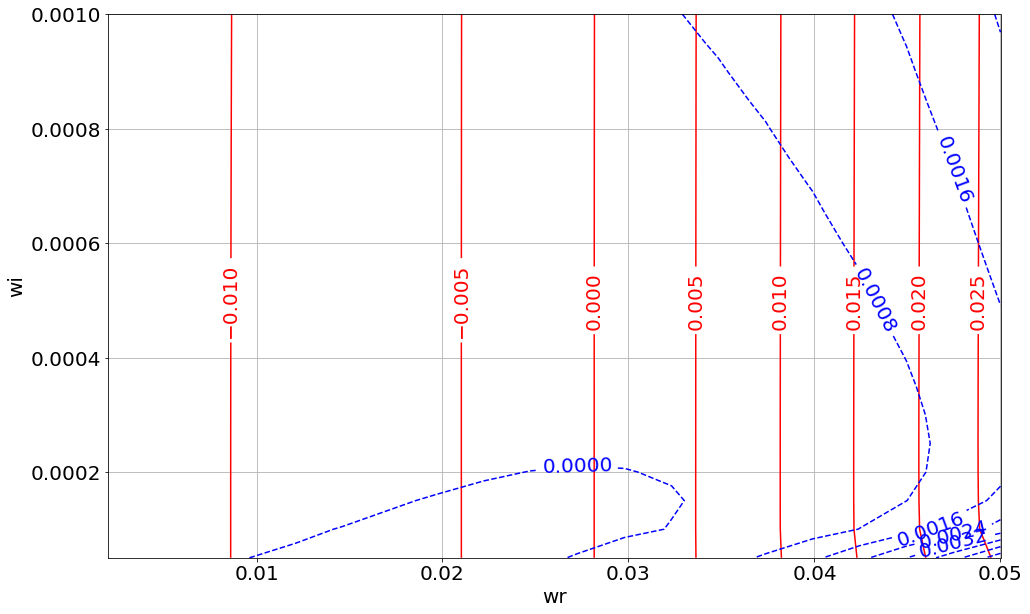

In [333]:
tic = datetime.now()

wrs = np.linspace(2e-3, 5e-2, num=20)
wis = np.linspace(5e-5, 1e-3, num=20)

detMr = []
detMi = []
for wr in wrs:
    dMr = []
    dMi = []
    for wi in wis:
        det = EH.multimode_matrix(kp, wr+1j*wi, lgT_interp_passing, z_spline_passing, lgT_interp_trapped, lgw_interp_trapped, z_spline_trapped, wnum=[100,100], spp=[10,100], num_res=3)
        dMr.append(np.real(det))
        dMi.append(np.imag(det))
    detMr.append(dMr)
    detMi.append(dMi)
    
detMr = np.array(detMr).T
detMi = np.array(detMi).T
toc = datetime.now()
print(toc-tic)

fig, ax = plt.subplots(figsize=(16,10))
CS = ax.contour(wrs,wis,detMr, colors='red',linestyles='solid')
ax.clabel(CS, CS.levels, colors='r', inline=True, fontsize=20)
CS = ax.contour(wrs,wis,detMi, colors='blue', linestyles='--')
ax.clabel(CS, CS.levels, colors='b', inline=True, fontsize=20)
plt.xlabel('wr')
plt.ylabel('wi')
plt.grid()
plt.show()

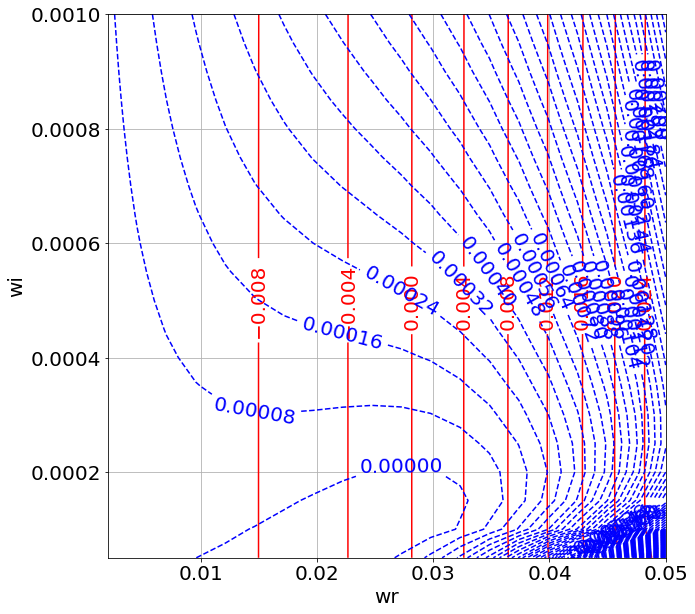

In [341]:
fig, ax = plt.subplots(figsize=(10,10))
CS = ax.contour(wrs,wis,detMr, colors='red',linestyles='solid', levels=10)
ax.clabel(CS, CS.levels, colors='r', inline=True, fontsize=20)
CS = ax.contour(wrs,wis,detMi, colors='blue', linestyles='--',levels=100)
ax.clabel(CS, CS.levels, colors='b', inline=True, fontsize=20)
plt.xlabel('wr')
plt.ylabel('wi')
plt.grid()
plt.show()

In [339]:
a = [0]*3
a[:5]

[0, 0, 0]

In [268]:
# tic = datetime.now()
# for w in [100, 400, 600, 800, 1000, 1500]:
#     kp = EH.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, lgwmin=-6, lgwmax=3, wnum=w, tnum=500, steps_per_period=10)
#     print(kp)
# toc = datetime.now()
# print(toc-tic)

# # %timeit EH.energy_integral_trapped(0.047+3.191257476806641e-05*1j, lgT_interp_trapped, z_spline_trapped, wnum=400, lgwmin=-7, tnum=100)

# tic = datetime.now()
# for w in [100, 400, 600, 800, 1000, 1500, 2000]:
#     kp, intgd, warray = EH.energy_integral_trapped(omega, lgT_interp_trapped, lgw_interp_trapped, z_spline_trapped, wnum=w, num_res=3, steps_per_period=80)
#     plt.semilogx(-warray, np.imag(intgd), '.')
#     print(kp)
    
# #plt.xlim([3.5e-3, 4e-3])
# #plt.ylim([-5, 1])
# plt.grid()
# plt.show()
# toc = datetime.now()
# print(toc-tic)

tic = datetime.now()
EH.growth_rate_shiftmode(0.028, lgT_interp_passing, z_spline_passing, lgT_interp_trapped, lgw_interp_trapped, z_spline_trapped, wi_low=1e-5, wi_high=1e-2, accuracy_tor=1e-5, parallel=False)
toc = datetime.now()
print(toc-tic)

0.0036909764908917746
0.0016189633618018595
0.0005795768441598016
5.948404054473082e-05
-0.00020060717695905667
-7.055879360753849e-05
-5.53669860334444e-06
0.028 0.000556328125 0.011010911401126413
0:00:06.647746


In [271]:
np.sqrt(0.011011)/(0.15*0.7)

0.9993648776748955

# disused code

In [ ]:
#     #Calculation of the table of tau(z,w) for passing particles(w>0).
#     def logtau_passing(self, lgwmin=1, lgwmax=9, lgwnum=9, wmin=1e-4, wmax=8, wnum=5000, znum=2000):
#         #tau is the time elapsed for the passing particles to arrive at position z>0 from position 0. 
#         #No need to worry about the case z<0 due to symmetry.
#         #We can simply look up this pre-calculated table to find out the time required to travel between any two positions z0 --> z. 
#         #It's better to store log(tau+1) since tau-->infty as z-->infty.
    
#         #Discretization of w(>0)
#         warray = np.array([self.height * 10**(-i) * np.linspace(lgwmin, lgwmax, num=lgwnum) for i in range(16,4,-1)]).reshape(-1,) #shape:(12*9,)
#         wex = self.height * np.linspace(wmin, wmax, num=wnum+1)
#         warray = np.hstack((warray, wex))
#         #warray = np.linspace(wmin, wmax, num=wnum)
#         zarray = np.linspace(-self.hole_region, self.hole_region, num=znum+1)
        
#         #The grid points in [w,z] space, note that tau is a function of w and z
#         wmesh, zmesh = np.meshgrid(warray, zarray)
#         #The integrand: 1/vz
#         vzinv = 1 / np.sqrt(2*(wmesh+self.potential(zmesh)))
#         #Find out tau(z,w)=int{dz/vz}
#         #tau = np.zeros_like(wmesh)

#         tau = cumtrapz(vzinv, zmesh, initial=0, axis=0)
            
#         tau_spline = RBS(zarray, np.log(warray), np.log(tau+1), kx=1, ky=1)

#         return tau_spline, warray


#     def orbit_integral_passing_discrete(self, z0=0.1, omega=0.04, tau_spline_passing=None, 
#                                warray=None, func=None, k=None, wnum=600, lgvzmin=-15, znum=200):
        
#         #orbit integral for passing particles
#         #omega --- frequency
#         #tau_spline_passing --- the interpolation function of tau for passing particles
#         #z0 --- the position where we want to evaluate the integral
#         #z --- the starting point of past trajectories
        
#         #Find out the indices of z0 and z in zarray and the time requires to go
#         #from z0 to z or from z to z0 for different energy w
#         phiz0 = self.potential(z0) if abs(z0)<self.hole_region else 0
        
#         vz0min, vz0max = np.sqrt(2*phiz0+2*warray[0]), np.sqrt(2*phiz0+2*warray[-1])
        
#         vz0 = vz0min + (vz0max-vz0min) * np.exp(np.linspace(lgvzmin, 0, num=wnum))
        
#         w = vz0**2/2 - phiz0
        
#         z = np.linspace(-self.hole_region, self.hole_region, num=znum)
        
#         tauz = tau_spline_passing.__call__(z, np.log(w))
        
#         if z0<-self.hole_region:
#             tauz0 = tau_spline_passing.__call__(-self.hole_region*np.ones_like(w), np.log(w), grid=False)
#             tau = np.abs(np.exp(tauz0.reshape(1,-1)) + (self.hole_region+z0) / vz0.reshape(1,-1) - np.exp(tauz))#shape: (len(z), len(w))
            
#         elif z0>self.hole_region:
#             tauz0 = tau_spline_passing.__call__(self.hole_region*np.ones_like(w), np.log(w), grid=False) 
#             tau = np.abs(np.exp(tauz0.reshape(1,-1)) + (z0-self.hole_region) / vz0.reshape(1,-1) - np.exp(tauz))#shape: (len(z), len(w))
#         else:
#             tauz0 = tau_spline_passing.__call__(z0*np.ones_like(w), np.log(w), grid=False)
#             tau = np.abs(np.exp(tauz0.reshape(1,-1)) - np.exp(tauz))#shape: (len(z), len(w))
    
#         z, w = z.reshape(-1,1), w.reshape(1,-1)
        
#         #fz = self.dpdz(z) if func is None else eval(f'self.{func}(z)')
#         if func is None:
#             fz = self.dpdz(z)
#         elif func=='MCAk':
#             fz = self.MCAk(k,z)
#         else:
#             fz = eval(f'self.{func}(z)')
        
#         intgd = 1j*omega * np.exp(1j*omega*tau) * self.dfdw(w) * fz / np.sqrt(2*w+2*self.potential(z))
        
#         return np.trapz(np.trapz(intgd, z, axis=0), vz0)
    
    
    
            
    
#     #when phi is one of the antisymmetric continuous mode
#     def orbit_integral_passing_continuous(self, z0=0.1, omega=0.04, k=0.1, tau_spline_passing=None, 
#                                warray=None, wnum=600, lgvzmin=-15, znum=200):
        
#         if z0<0:
#             return -self.orbit_integral_passing_continuous(-z0, omega, k, tau_spline_passing, warray, wnum, lgvzmin, znum)
        
#         phiz0 = self.potential(z0) if abs(z0)<self.hole_region else 0
        
#         vz0min, vz0max = np.sqrt(2*phiz0+2*warray[0]), np.sqrt(2*phiz0+2*warray[-1])
        
#         vz0 = vz0min + (vz0max-vz0min) * np.exp(np.linspace(lgvzmin, 0, num=wnum))
        
#         w = vz0**2/2 - phiz0
        
#         z = np.linspace(-self.hole_region, self.hole_region, num=znum)
        
#         tauz = tau_spline_passing.__call__(z, np.log(w))
#         taul = tau_spline_passing.__call__(-self.hole_region*np.ones_like(w), np.log(w), grid=False)
#         taur = tau_spline_passing.__call__(self.hole_region*np.ones_like(w), np.log(w), grid=False)
        
        
#         if z0>self.hole_region:    
            
#             kn = k / self.width
#             dtau = np.abs(np.exp(taur) - np.exp(taul))
#             tauh = (z0-self.hole_region)/vz0
            
#             intgd = omega * self.dfdw(w) * (
#                     #2*omega * np.exp(1j*kn*z0) / (kn**2 * vz0**2 - omega**2) +
#                     np.exp(1j*(kn*self.hole_region+omega*tauh)) / (omega-kn*vz0) +
#                     np.exp(1j*(kn*self.hole_region+omega*tauh+omega*dtau)) / (omega+kn*vz0)
#                     )
#             Iext = (np.trapz(intgd, vz0) * (1j*k-1)*(1j*k-2)*(1j*k-3)*(1j*k-4)*(1j*k-5) / np.sqrt(2*np.pi*self.width) /
#                     np.sqrt(k**2+1) / np.sqrt(k**2+4) / np.sqrt(k**2+9) / np.sqrt(k**2+16) / np.sqrt(k**2+25)
#                     )
            
#             tau = np.abs(np.exp(taur.reshape(1,-1)) - np.exp(tauz)) + tauh.reshape(1,-1)#shape: (len(z), len(w))
#             z, w = z.reshape(-1,1), w.reshape(1,-1)
#             intgd = 1j*omega * np.exp(1j*omega*tau) * self.dfdw(w) * self.MCAk(k,z) / np.sqrt(2*w+2*self.potential(z))
#             Iin = np.trapz(np.trapz(intgd, z, axis=0), vz0) 
            
#         else:
            
#             kn = k / self.width
#             tauz0 = tau_spline_passing.__call__(z0*np.ones_like(w), np.log(w), grid=False)
#             taul = np.abs(np.exp(tauz0) - np.exp(taul))
#             taur = np.abs(np.exp(taur) - np.exp(tauz0))
#             intgd = omega * self.dfdw(w) * np.exp(1j*kn*self.hole_region) * (np.exp(1j*omega*taul)-np.exp(1j*omega*taur)) / (omega+kn*np.sqrt(2*w))
#             Iext = (np.trapz(intgd, vz0) * (1j*k-1)*(1j*k-2)*(1j*k-3)*(1j*k-4)*(1j*k-5) / np.sqrt(2*np.pi*self.width) /
#                     np.sqrt(k**2+1) / np.sqrt(k**2+4) / np.sqrt(k**2+9) / np.sqrt(k**2+16) / np.sqrt(k**2+25)
#                     )
#             Iext += omega/np.sqrt(2)/kn * plasma_dispersion_func(omega/np.sqrt(2)/kn) * self.MCAk(k, z0)
            
#             tau = np.abs(np.exp(tauz0.reshape(1,-1)) - np.exp(tauz)) #shape: (len(z), len(w))
#             z, w = z.reshape(-1,1), w.reshape(1,-1)
#             intgd = 1j*omega * np.exp(1j*omega*tau) * self.dfdw(w) * self.MCAk(k,z) / np.sqrt(2*w+2*self.potential(z))
#             Iin = np.trapz(np.trapz(intgd, z, axis=0), vz0)
            
#         return Iin + Iext           
    
# #     def tau_integral_trapped(self, omega, warray, lgTq_interp, z_spline, func=None, k=None, steps_per_period=100):
        
# #         lgw = -np.log10(-warray/self.height) #shape:(Nw, )
    
# #         Tq = 10**(lgTq_interp(lgw)) #shape:(Nw, )
        
# #         zmax = np.arccosh((-warray/self.height)**(-1/4)) * self.width #shape:(Nw, )
        
# #         tstep = 2*np.pi/np.abs(omega)/steps_per_period
        
# #         #resonances Tq=(k+1/2)*np.pi/omega
# #         t_norm = np.linspace(0, 1, num=int(max(Tq)/tstep))**3 #shape:(Nt, )
        
# #         z = z_spline.__call__(t_norm, lgw) ** (1/2/lgw.reshape(1,-1)) * zmax.reshape(1,-1)  #shape:(Nt, Nw)
        
# #         if func is None:
# #             fz = self.MD4(z) #shape:(Nt, Nw)
# #         elif func=='MCAk':
# #             fz = self.MCAk(k,z)
# #         else:
# #             fz = eval(f'self.{func}(z)')
    
# #         t = np.dot(t_norm.reshape(-1,1), Tq.reshape(1,-1)) #shape:(Nt, Nw)
        
# #         Fp = cumtrapz(fz*np.exp(1j*omega*t), x=t, initial=0, axis=0) #shape:(Nt, Nw)
        
# #         Fn = cumtrapz(fz*np.exp(-1j*omega*t), x=t, initial=0, axis=0) #shape:(Nt, Nw)
        
# #         Fpr_spline = RBS(t_norm, lgw, np.real(Fp), kx=1, ky=1)
        
# #         Fpi_spline = RBS(t_norm, lgw, np.imag(Fp), kx=1, ky=1)
        
# #         Fnr_spline = RBS(t_norm, lgw, np.real(Fn), kx=1, ky=1)
        
# #         Fni_spline = RBS(t_norm, lgw, np.imag(Fn), kx=1, ky=1)
        
# #         return Fpr_spline, Fpi_spline, Fnr_spline, Fni_spline


# #     def energy_integral_trapped(self, z0, Tq_interp, tau_spline, z_spline, Fpr_spline, Fpi_spline, Fnr_spline, Fni_spline, wnum=1000, lgwmin=-15):
        
# #         wmin, wmax = -self.potential(z0), -self.height*1e-10
        
# #         warray = wmax - (wmax-wmin) * np.logspace(0, lgwmin, num=wnum+1)
        
# #         vz0 = np.sqrt(2*(warray+self.potential(z0)))
        
# #         zmax = np.arccosh((-warray/self.height)**(-1/4)) * self.width
        
# #         z_norm = z0 / zmax
        
# #         lgw = -np.log10(-warray/self.height)
        
# #         Tq = Tq_interp(lgw)
        
# #         t0_norm = (tau_spline.ev(z_norm, lgw) ** (2*lgw))
        
# #         Fpt0 = Fpr_spline.ev(t0_norm, lgw) + 1j * Fpi_spline.ev(t0_norm, lgw)
# #         Fnt0 = Fnr_spline.ev(t0_norm, lgw) + 1j * Fni_spline.ev(t0_norm, lgw)
# #         FpTq = Fpr_spline.ev(1, lgw) + 1j * Fpi_spline.ev(1, lgw)
# #         FnTq = Fnr_spline.ev(1, lgw) + 1j * Fni_spline.ev(1, lgw)   
        
# #         intgd = np.exp(1j*omega*t0_norm*Tq)*Fnt0 - np.exp(-1j*omega*t0_norm*Tq)*Fpt0 \
# #                 + (FpTq+np.exp(1j*2*omega*Tq)*FnTq) / (1+np.exp(1j*2*omega*Tq)) * (np.exp(-1j*omega*t0_norm*Tq)-np.exp(1j*omega*t0_norm*Tq))

        
# #         return np.trapz(self.dfdw(warray)*intgd, vz0), warray, intgd
        
    

    
# #     Calculation of the table of tau(alphaz,alphaw) for trapped particles(w<0).
# #     where alphaz = z/zmax, alphaw = -log[(wmax-w)/(wmax-wmin)].
# #     tau is the time elapsed for the trapped particles to arrive at position z>0 from position 0. 
# #     No need to worry about the case z<0 due to symmetry.
# #     We can simply look up this pre-calculated table to find out the time required to travel between any two positions z0 --> z. 
# #     It's better to store log(tau+1) since tau-->infty as z-->infty.
#     def logtau_trapped(self, wnum=5000, znum=6000):

#         wmin, wmax = -self.height * (1-1e-6), -1e-20 #-self.potential(self.hole_region)

#         #warray = wmax - (wmax-wmin) * np.exp(np.linspace(0, lgwmin, num=wnum))
#         warray = np.linspace(wmin, wmax, num=wnum+1)

#         zmax = np.arccosh((-warray/self.height)**(-1/4)) * self.width
        
#         #zmax[zmax>self.hole_region] = self.hole_region

#         z_norm = np.linspace(0, 1, num=znum+1).reshape(-1,1)

#         zmesh = np.dot(z_norm[:-1,:], zmax.reshape(1,-1))

#         wmesh = np.dot(np.ones((z_norm.size-1,1)), warray.reshape(1,-1))

#         #The inverse of vz which is the integrand of tau-integral
#         vzinv = 1 / np.sqrt(2*(wmesh+self.potential(zmesh)))

#         #Find out tau(z,w)
#         tau = cumtrapz(vzinv, zmesh, initial=0, axis=0)

#         #First order correction to the sojourn time near the turning points
#         taucr = np.sqrt(2/znum*zmax / np.abs(self.dpdz(zmax)))
#         #Quarter period of each orbit with energy w<0
#         Tq = tau[-1,:] + taucr
    
#         #Saving up w,z together with tau into matrix t
#         tau = np.vstack((tau, Tq.reshape(1,-1)))

#         tau_spline = RBS(z_norm, -np.log(-warray/self.height), np.log(tau+1), kx=1, ky=1)

#         return tau_spline, warray[-1]
    

    

#     def orbit_integral_trapped(self, z0=0.1, omega=0.04, tau_spline_trapped=None, func=None, k=None,
#                                lgvzmin=-15, wmax=-1e-6, wnum=400, zmaxmin=1e-9, zturn=1e-2, znum=200):
#         #orbit integral for trapped particles
#         #omega --- frequency
#         #tau_spline_trapped --- the interpolation function of tau for trapped particles
#         #z0 --- the position where we want to evaluate the integral

#         if abs(z0)>self.hole_region or z0==0:  
#             return 0
        
#         elif z0<0: #func should be antisymmetric
#             return -self.orbit_integral_trapped(-z0, omega, tau_spline_trapped, func, k, lgvzmin, wmax, wnum, zmaxmin, zturn, znum)
        
#         #Spacing of energy (or vz0). Equal spacing is not a good way. The principle is
#         #to resolve the extreme cases: w=0 which corresponds to that the particle 
#         #goes very far towards the infinity; vz0=0 which corresponds to that initially 
#         #the particle is at a turning point.
#         phiz0 = self.potential(z0)
#         vz0min, vz0max = 0, np.sqrt(2*(wmax+phiz0))
#         vz0 = vz0max - (vz0max-vz0min) * np.exp(np.linspace(0, lgvzmin, num=wnum)) #shape(len(w),)
#         w = vz0**2/2 - phiz0 #shape(len(w),)

#         #find out the value of alphaw which is needed for interpolation later
#         lgw_norm = -np.log(-w/self.height) #shape(len(w),)
#         #print(w[-1], lgw_norm[-1])


#         #position of turning point
#         zmax = np.arccosh((-w/self.height)**(-1/4)) * self.width #shape(len(w),)
#         zmax[zmax==0] = zmaxmin

#         #relative position in the trajectory of a trapped particle, defined as the
#         #ratio of z0/zmax
#         z0_norm = z0 / zmax #shape(len(w),)
#         z0_norm[z0_norm>=1] = 1

#         tauz0 = tau_spline_trapped.__call__(z0_norm, lgw_norm, grid=False) #shape(len(w),)
#         tauz0 = np.exp(tauz0.reshape(1,-1)) - 1 #shape(1,len(w))
#         Tq = tau_spline_trapped.__call__(np.ones_like(w), lgw_norm, grid=False) #shape(len(w),)
#         Tq = np.exp(Tq.reshape(1,-1)) - 1 #shape(1,len(w))
        
#         z_norm = np.linspace(0, 1-zturn, num=znum+1)
#         tauz = tau_spline_trapped.__call__(z_norm, lgw_norm) #shape(len(z), len(w))
#         tauz = np.exp(tauz) - 1

#         tau1 = np.abs(tauz-tauz0) #shape(len(z), len(w))
#         tau2 = np.abs(tauz+tauz0+2*Tq) #shape(len(z), len(w))
#         tau3 = np.abs(tauz+tauz0) #shape(len(z), len(w))
#         tau4 = np.abs(-tauz+tauz0+2*Tq) #shape(len(z), len(w))

#         z = z_norm.reshape(-1,1) * zmax#shape(len(z), len(w))
#         zmax = zmax.reshape(1,-1)
#         w = w.reshape(1,-1)
        
#         if func is None:
#             fz = self.dpdz(z)
#             fzmax = self.dpdz(zmax)
#         elif func=='MCAk':
#             fz = self.MCAk(k,z)
#             fzmax = self.MCAk(k,zmax)
#         else:
#             fz = eval(f'self.{func}(z)')
#             fzmax = eval(f'self.{func}(zmax)')
      
#         intgd = fz / np.sqrt(2*w+2*self.potential(z)) / (1-np.exp(4j*omega*Tq)) * (
#                 np.exp(1j*omega*tau1) + np.exp(1j*omega*(4*Tq-tau1)) + np.exp(1j*omega*tau2) + np.exp(1j*omega*(4*Tq-tau2)) -
#                 np.exp(1j*omega*tau3) - np.exp(1j*omega*(4*Tq-tau3)) - np.exp(1j*omega*tau4) - np.exp(1j*omega*(4*Tq-tau4)))
        
#         intgd2 = np.trapz(intgd, x=z, axis=0) + fzmax * np.sqrt(8*zturn*zmax/np.abs(self.dpdz(zmax))) / (1-np.exp(4j*omega*Tq)) * (
#                  np.exp(1j*omega*(Tq-tauz0)) + np.exp(1j*omega*(3*Tq+tauz0)) - np.exp(1j*omega*(Tq+tauz0)) - np.exp(1j*omega*(3*Tq-tauz0))
#                  ) #correction
        
#         intgd2 = 1j*omega * self.dfdw(w) * intgd2
        
#         return np.trapz(intgd2.reshape(-1,), x=vz0)

In [3]:
#comparison with Ian's code outputs
# data_Ian = np.genfromtxt('bench.txt', delimiter='')
# print(Ian_data.shape)
# plt.plot(data_Ian[:,1], np.real(2j*omega*(data_Ian[:,5]+1j*data_Ian[:,6])), '--.')
# plt.plot(data_Ian[:,1], np.real(4*np.tan(omega*data_Ian[:,2]/2)/omega-data_Ian[:,2]*2))
# plt.grid()
# plt.xlim([-0.11,-0.0005])
# plt.ylim([-1e3,1e3])
# plt.show()
# print(4j*omega*np.trapz(data_Ian[:,3]+1j*data_Ian[:,4], data_Ian[:,1]))
# print(4j*omega*np.trapz(data_Ian[:,5]+1j*data_Ian[:,6], data_Ian[:,1]))

#Xiang's benchmark
# Tq = 10**(lgTq_interp_trapped(lgw))
# print(4*np.trapz(np.tan(omega*Tq)/omega-Tq, EH.distribution(warray)))
# plt.loglog(-warray, np.abs(np.real(np.tan(omega*Tq)/omega-Tq)))
# plt.show()
# plt.plot(warray, np.real(np.tan(omega*Tq)/omega-Tq))
# plt.ylim([-100, 100])
# plt.grid()
# plt.show()

<ipython-input-166-09691a73e0b5>:261: RuntimeWarning: invalid value encountered in sqrt
  vz = np.sqrt(2*(wmesh+self.potential(zmesh)))


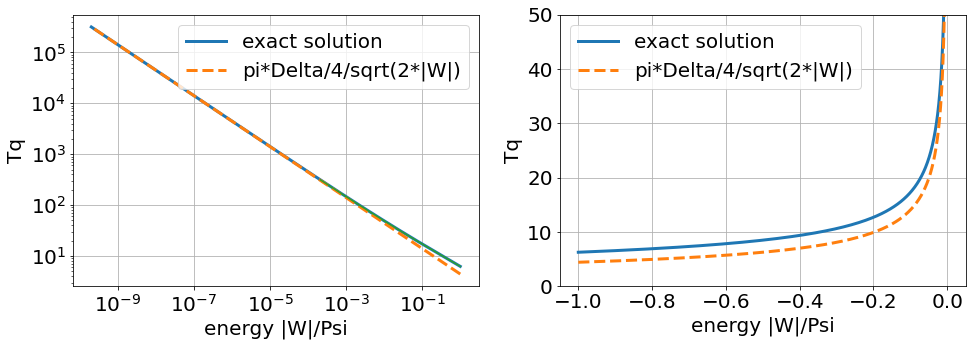

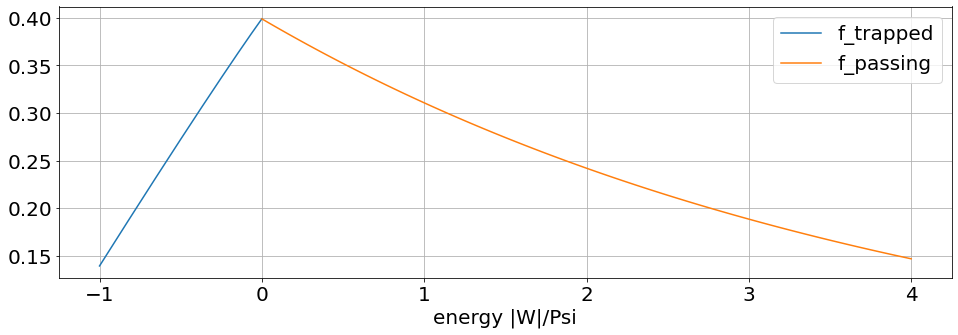

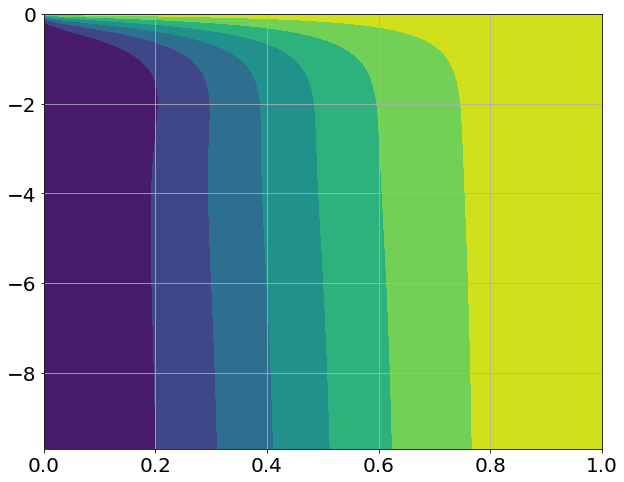

In [169]:
#lgTq_interp_trapped, z_spline_trapped, _ = EH.tau_map_trapped(wnum=200, tnum=1e4, znum=1e5, lgwmin=-10, frac=0.3)
lgTq_interp_trapped, lgw_interp_trapped, z_spline_trapped, _ = EH.tau_map_trapped(wnum=400, tnum=1e4, znum=1e5, lgwmin=-10, frac=0.3)

#-self.height * (1-1e-10), -self.height * 1e-20
wmin, wmax = -EH.height*(1-1e-10), -EH.height*1e-10
warray = wmax - (wmax-wmin) * np.logspace(0, -10, num=2000+1)
lgw = -np.log10(-warray/EH.height)

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].loglog(-warray/EH.height, 10**(lgTq_interp_trapped(lgw)), linewidth=3, label='exact solution')
ax[0].loglog(-warray/EH.height, np.pi/np.sqrt(-2*warray), linestyle='--', linewidth=3, label='pi*Delta/4/sqrt(2*|W|)')
ax[0].loglog(x,y)
#ax[0].loglog(-Tb[:,1]/EH.height, Tb[:,-1]/2, linewidth=3, label='Ian')
ax[0].set_xlabel('energy |W|/Psi')
ax[0].set_ylabel('Tq')
ax[0].legend()
ax[0].grid()

ax[1].plot(warray/EH.height, 10**(lgTq_interp_trapped(lgw)), linewidth=3, label='exact solution')
ax[1].plot(warray/EH.height, np.pi/np.sqrt(-2*warray), linestyle='--', linewidth=3, label='pi*Delta/4/sqrt(2*|W|)')
#ax[1].plot(Tb[:,1]/EH.height, Tb[:,-1]/2, linewidth=3, label='Ian')
ax[1].set_xlabel('energy |W|/Psi')
ax[1].set_ylabel('Tq')
ax[1].set_ylim([0, 50])
ax[1].legend()
ax[1].grid()
plt.show()

fig, ax = plt.subplots(1,1, figsize=(16,5))
plt.plot(warray/EH.height, EH.distribution(warray), label='f_trapped')
plt.plot(np.linspace(0, 1, num=100)/EH.height, EH.distribution(np.linspace(0, 1, num=100)), label='f_passing')
plt.xlabel('energy |W|/Psi')
plt.legend()
plt.grid()
plt.show()


tau_norm = np.linspace(0, 1, num=int(1e3)+1)
zq = z_spline_trapped.__call__(tau_norm, lgw)

fig, ax = plt.subplots(1,1, figsize=(10,8))
plt.contourf(tau_norm, -lgw, zq.T)
plt.grid()
plt.show()

# lgT_interp_passing, z_spline_passing = EH.tau_map_passing(lgwmin=-6, lgwmax=3, wnum=1000, znum=1000, tnum=1000)

# lgwarray = np.linspace(-6, 2, num=100)
# warray = EH.height * 10**(lgwarray)
# period = 10**lgT_interp_passing(lgwarray)
# plt.loglog(warray, period)
# plt.show()

# tau_norm = np.linspace(0, 1, num=1000)
# z = z_spline_passing.__call__(tau_norm, lgwarray)

# fig, ax = plt.subplots(1,1, figsize=(10,8))
# plt.contourf(tau_norm, lgwarray, z.T)
# plt.colorbar()
# plt.grid()
# plt.show()    

In [60]:
Ipqq, _, warray = EH.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='MCAk', kX=q0, funcY='MCAk', 
                              kY=q0, lgwmin=-6, lgwmax=3, wnum=400, tnum=500, steps_per_period=100)

Itqq, _, _ = EH.energy_integral_trapped(omega, lgTq_interp_trapped, z_spline_trapped, funcX='MCAk', kX=q0, funcY='MCAk', kY=q0, wnum=400, lgwmin=-7, tnum=2000)

print(Ipqq)
print(Itqq)
print(Ipqq+Itqq)

# Ipqq, _, _ = EH.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='MCAk', kX=-q0, funcY='MCAk', 
#                               kY=-q0, lgwmin=-6, lgwmax=3, wnum=400, tnum=500, steps_per_period=100)

# Itqq, _, _ = EH.energy_integral_trapped(omega, lgTq_interp_trapped, z_spline_trapped, funcX='MCAk', kX=-q0, funcY='MCAk', kY=-q0, wnum=400, lgwmin=-7, tnum=2000)

# print(Ipqq)
# print(Itqq)
# print(Ipqq+Itqq)

(183.82000545405384+105.44994754579042j) 0.12516992730317256
(87.93686544344001+141.40994295790568j) 0.12516992730317256
(36.49489217447368+170.81927367830252j) 0.12516992730317256
(-14.947081094492411+200.2286043986993j) 0.12516992730317256
(5.9839360417990655+176.7029087242167j) 0.12516992730317256
(2.3546720092522184+34.82140235868795j) 0.12516992730317256
(44.05114237719221+32.54555934986339j) 0.12516992730317256
(0.3737492830256419-1.4686202220282052j)
(-0.0008490299960948195+0.014140923778583829j)
(0.3729002530295471-1.4544792982496213j)


In [205]:
#EH = electronHole(height=0.7)
Ip44, _, _ = EH.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='self.MD4', kX=None, funcY='self.MD4', 
                              kY=None, lgwmin=-6, lgwmax=2, wnum=400, tnum=500, steps_per_period=100)

Ip22, _, _ = EH.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='self.MD2', kX=None, funcY='self.MD2', 
                              kY=None, lgwmin=-6, lgwmax=2, wnum=400, tnum=500, steps_per_period=100)

Ipqq, _, _ = EH.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='MCAk', kX=q0, funcY='MCAk', 
                              kY=q0, lgwmin=-6, lgwmax=3, wnum=400, tnum=500, steps_per_period=100)

Ip42, _, _ = EH.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='self.MD4', kX=None, funcY='self.MD2', 
                              kY=None, lgwmin=-6, lgwmax=2, wnum=400, tnum=500, steps_per_period=100)

Ip24, _, _ = EH.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='self.MD2', kX=None, funcY='self.MD4', 
                              kY=None, lgwmin=-6, lgwmax=2, wnum=400, tnum=500, steps_per_period=100)

Ip2q, _, _ = EH.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='self.MD2', kX=None, funcY='MCAk', 
                              kY=q0, lgwmin=-6, lgwmax=3, wnum=400, tnum=500, steps_per_period=100)

Ipq2, _, _ = EH.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='MCAk', kX=q0, funcY='self.MD2', 
                              kY=None, lgwmin=-6, lgwmax=3, wnum=400, tnum=500, steps_per_period=100)

Ip4q, _, _ = EH.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='self.MD4', kX=None, funcY='MCAk', 
                              kY=q0, lgwmin=-6, lgwmax=3, wnum=400, tnum=500, steps_per_period=100)

Ipq4, _, _ = EH.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='MCAk', kX=q0, funcY='self.MD4', 
                              kY=None, lgwmin=-6, lgwmax=3, wnum=400, tnum=500, steps_per_period=100)

# plt.semilogx(res[-1], np.real(res[1]), '.')
# plt.grid()
# plt.show()
# plt.plot(EH.distribution(res[-1]), np.real(res[1]))
# plt.show()


# %timeit Fpr_spline, Fpi_spline, Fnr_spline, Fni_spline = EH.tau_integral_trapped(0.047+1j*0.00119, warray, lgTq_interp, z_spline, func=None, k=0.0068, steps_per_period=100)

It44, _, _ = EH.energy_integral_trapped(omega, lgTq_interp_trapped, z_spline_trapped, funcX='self.MD4', kX=None, funcY='self.MD4', kY=None, wnum=400, lgwmin=-7, tnum=2000)

It22, _, _ = EH.energy_integral_trapped(omega, lgTq_interp_trapped, z_spline_trapped, funcX='self.MD2', kX=None, funcY='self.MD2', kY=None, wnum=400, lgwmin=-7, tnum=2000)

Itqq, _, _ = EH.energy_integral_trapped(omega, lgTq_interp_trapped, z_spline_trapped, funcX='MCAk', kX=q0, funcY='MCAk', kY=q0, wnum=400, lgwmin=-7, tnum=2000)

It42, _, _ = EH.energy_integral_trapped(omega, lgTq_interp_trapped, z_spline_trapped, funcX='self.MD4', kX=None, funcY='self.MD2', kY=None, wnum=400, lgwmin=-7, tnum=2000)

It24, _, _ = EH.energy_integral_trapped(omega, lgTq_interp_trapped, z_spline_trapped, funcX='self.MD2', kX=None, funcY='self.MD4', kY=None, wnum=400, lgwmin=-7, tnum=2000)

Itq4, _, _ = EH.energy_integral_trapped(omega, lgTq_interp_trapped, z_spline_trapped, funcX='MCAk', kX=q0, funcY='self.MD4', kY=None, wnum=400, lgwmin=-7, tnum=2000)

It4q, _, _ = EH.energy_integral_trapped(omega, lgTq_interp_trapped, z_spline_trapped, funcX='self.MD4', kX=None, funcY='MCAk', kY=q0, wnum=400, lgwmin=-7, tnum=2000)

It2q, _, _ = EH.energy_integral_trapped(omega, lgTq_interp_trapped, z_spline_trapped, funcX='self.MD2', kX=None, funcY='MCAk', kY=q0, wnum=400, lgwmin=-7, tnum=2000)

Itq2, _, _ = EH.energy_integral_trapped(omega, lgTq_interp_trapped, z_spline_trapped, funcX='MCAk', kX=q0, funcY='self.MD2', kY=None, wnum=400, lgwmin=-7, tnum=2000)

# plt.plot(EH.distribution(res[-1]), np.real(res[1]))
# plt.show()

Ipqq1, _, _ = EH.energy_integral_passing(omega, lgT_interp_passing, z_spline_passing, funcX='MCAk', kX=-q0, funcY='MCAk', 
                              kY=q0, lgwmin=-6, lgwmax=3, wnum=400, tnum=500, steps_per_period=100)

Itqq1, _, _ = EH.energy_integral_trapped(omega, lgTq_interp_trapped, z_spline_trapped, funcX='MCAk', kX=-q0, funcY='MCAk', kY=q0, wnum=400, lgwmin=-7, tnum=2000)

Iqq1 = Ipqq1 + Itqq1

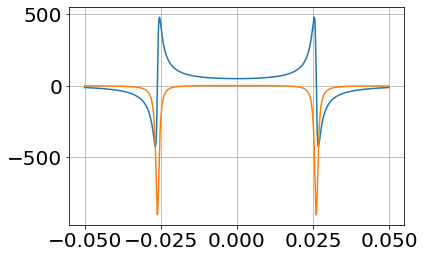

(-13.220276909713576+3.73379131518906j)


In [230]:
#showing that Residue's theorem can be applied to wavenumber-integral
k = np.linspace(-0.05,0.05, num=int(1e4))
plt.plot(k, np.real(1/EH.gamma(omega, kp, k/EH.width)))
plt.plot(k, np.imag(1/EH.gamma(omega, kp, k/EH.width)))
#plt.xlim([0.5,1])
plt.grid()
plt.show()

k = np.hstack([np.linspace(-1000,-100, num=int(1e5)), 
               np.linspace(-100,-10, num=int(1e5)), 
               np.linspace(-10,-1, num=int(1e5)), 
               np.linspace(-1,-0.05, num=int(1e5)),
               np.linspace(-0.05,0.05, num=int(1e5)), 
               np.linspace(0.05,1, num=int(1e5)), 
               np.linspace(1,10, num=int(1e5)), 
               np.linspace(10,100, num=int(1e5)), 
               np.linspace(100,1000, num=int(1e5))])
print(np.trapz(k, 1/EH.gamma(omega, kp, k/EH.width)))

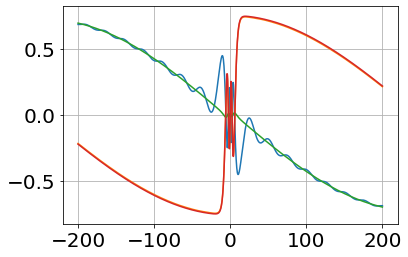

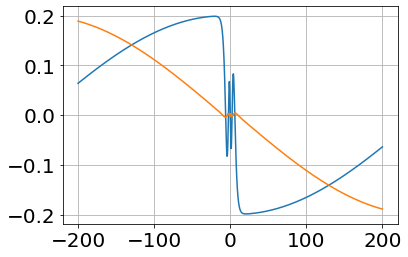

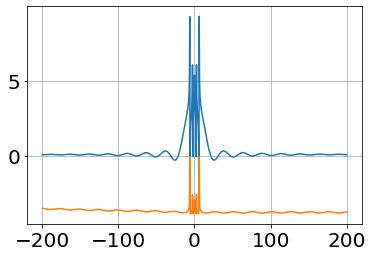

(0.09285770089095906-3.7584074833547065j)


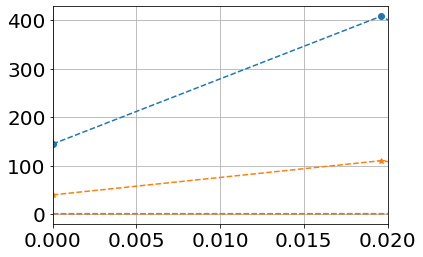

In [48]:
#showing that Residue's theorem can be applied to wavenumber-integral
k = np.linspace(-1,1, num=int(1e5))
z = np.linspace(-200, 200, num=1000)
Mmix = [np.trapz(EH.MCAk(-k, zi)/EH.gamma(omega, kp, k/EH.width), k) for zi in z]
plt.plot(z, np.real(Mmix))
plt.plot(z, np.imag(Mmix))
plt.plot(z, np.real(EH.MCAk(q0*0.948, z)*(0.07406424648659644-3.784557091447719j)*np.exp(-1.66*1e-4*abs(z))))
plt.plot(z, np.imag(EH.MCAk(q0*0.948, z)*(0.07406424648659644-3.784557091447719j)*np.exp(-1.66*1e-4*abs(z))))
plt.grid()
plt.show()
kz = np.fft.fftfreq(len(z[200:]), z[1]-z[0])*2*np.pi
sp = np.abs(np.fft.fft(Mmix[200:]))
kz0 = kz[np.argmax(sp)]
#print(kz0)

plt.plot(z, np.real(EH.MCAk(q0*0.948, z)))
plt.plot(z, np.imag(EH.MCAk(q0*0.948, z)))
plt.grid()
plt.show()

Kz = Mmix/EH.MCAk(q0*0.948, z)*np.exp(1.66*1e-4*z) #/EH.MCAk(q0*0.948, 0.02)
plt.plot(z, np.real(Kz))
plt.plot(z, np.imag(Kz))
plt.grid()
#plt.ylim([0,4])
plt.show()
print(np.mean(Kz[-200:]))

plt.plot(kz, sp, '--o')
plt.plot(kz, np.abs(np.fft.fft(EH.MCAk(q0*0.948, z[200:]))), '--*')
plt.xlim([0,2e-2])
plt.grid()
plt.show()

[[ 0.27 +0.1j  -0.01 +0.15j -0.02 +0.08j]
 [-0.01 +0.15j -0.13 +0.22j -0.12 +0.18j]
 [-0.03 +0.09j -0.14 +0.22j -3.26-33.92j]]
w2=(-0.047807434920446604+0.15121938750028385j)
wq=(0.07895628972142194+0.014254769566471625j)


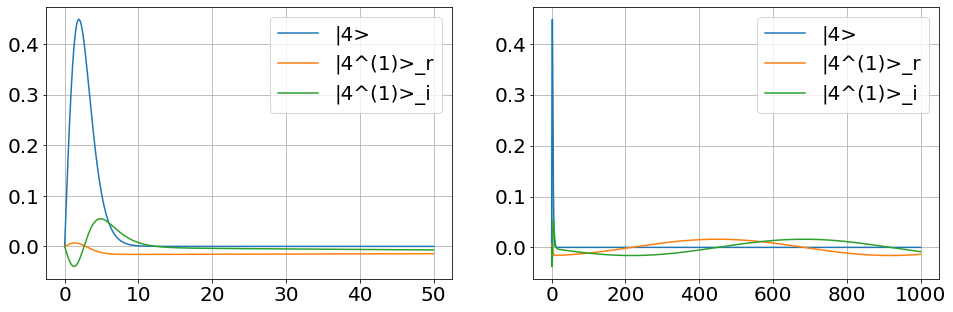

11.593992497505928
3.417702277798921


In [218]:
I44 = Ip44+It44
I22 = Ip22+It22
Iqq = Ipqq+Itqq
I42 = Ip42+It42
I24 = Ip24+It24
I4q = Ip4q+It4q
Iq4 = Ipq4+Itq4
I2q = Ip2q+It2q
Iq2 = Ipq2+Itq2
#overlap intergal matrix
M = [[I44, I42, I4q], [I24, I22, I2q], [Iq4, Iq2, Iqq]]
print(np.round(M,2)) 

#K = -np.pi*16/12.1719*1j 
K = 0.07912961467990776-3.7786187967896896j
w2 = I24/(kp**2+0.75-I22)
wq = K*Iq4/(1-K*Iqq1)
#wq = K*(I4q+w2*I2q)/(1-K*Iqq1)
# wq = K*(I4q*(kp**2+0.75-I22)+I2q*I24)/((1-K*Iqq1)*(kp**2+0.75-I22)-K*I2q**2)
# w2 = (I24+wq*I2q)/(kp**2+0.75-I22)
print(f'w2={w2}')
print(f'wq={wq}')

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
z = np.linspace(0, 50, num=1000)
ax[0].plot(z, EH.MD4(z), label='|4>')
ax[0].plot(z, np.real(w2*EH.MD2(z) + wq*EH.MCAk(q0,z)), label='|4^(1)>_r')
ax[0].plot(z, np.imag(w2*EH.MD2(z) + wq*EH.MCAk(q0,z)), label='|4^(1)>_i')
ax[0].grid()
ax[0].legend()
ax[0].set_label('z')
z = np.linspace(0, 1000, num=1000)
ax[1].plot(z, EH.MD4(z), label='|4>')
ax[1].plot(z, np.real(w2*EH.MD2(z) + wq*EH.MCAk(q0,z)), label='|4^(1)>_r')
ax[1].plot(z, np.imag(w2*EH.MD2(z) + wq*EH.MCAk(q0,z)), label='|4^(1)>_i')
ax[1].grid()
ax[1].legend()
ax[1].set_label('z')
plt.show()

print(abs(I44/(w2*I42+wq*I4q)))
print(abs(I24/(w2*I22+wq*I2q)))
#print(abs(Iq4/(w2*Iq2+wq*Iqq))) not this one

(5.9998135542251205+0.0008070709559833134j)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


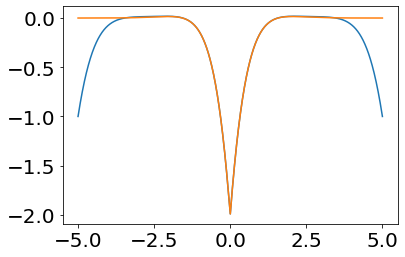

In [198]:
kt = 1+2j
x = np.linspace(-5,5,num=2000)
y = x.copy()
xmesh, ymesh = np.meshgrid(x,y)
print(kt**2*(np.trapz(np.trapz(np.sign(xmesh*ymesh)*np.exp(1j*kt*np.abs(xmesh-ymesh)),x),y)+4*x[-1]/1j/kt))

plt.plot(x, -2-1j*kt*np.trapz(np.sign(xmesh*ymesh)*np.exp(1j*kt*np.abs(xmesh-ymesh)),y))
plt.plot(x, -2*np.exp(1j*kt*np.abs(x)))
plt.show()

In [5]:
# print('                      Ian               Xiang,         Ian/Xiang')
# print(f'<4|V|4>,passing = -0.0311-0.0172j,  {Ip44:.4f},  {(-0.0311-0.0172j)/Ip44:.2f}')
# print(f'<4|V|4>,trapped = 0.6054+0.2472j,   {It44:.4f},   {(0.6054+0.2472j)/It44:.2f}')
# print(' ')
# print(f'<4|V|2>,passing = -0.0345-0.0502j,  {Ip24:.4f},  {(-0.0345-0.0502j)/Ip24:.2f}')
# print(f'<4|V|2>,trapped =  0.0539+0.7380j,  {It24:.4f},   {(0.0539+0.7380j)/It24:.2f}')
# print(' ')
# print(f'<2|V|4>,passing = -0.0346-0.0503j,  {Ip24:.4f},  {(-0.0346-0.0503j)/Ip24:.2f}')
# print(f'<2|V|4>,trapped = 0.0442+0.7373j,   {It24:.4f},   {(0.0442+0.7373j)/It24:.2f}')
# print(' ')
# print(f'<4|V|q>,passing = 0.0506-0.04000j,  {Ip4q:.4f},  {(0.0506-0.0400j)/Ip4q:.2f}')
# print(f'<4|V|q>,trapped = -0.0530-0.1367j,  {It4q:.4f},   {(-0.0530-0.1367j)/It4q:.2f}')
# print(' ')
# print(f'<q|V|4>,passing = 0.0598-0.053j,    {Ipq4:.4f},  {(0.0598-0.053j)/Ipq4:.2f}')
# print(f'<q|V|4>,trapped = -0.0608-0.1435j,  {Itq4:.4f},   {(-0.0608-0.1435j)/Itq4:.2f}')

In [111]:
#|2> = sqrt(105/delta)/4 * [2*S^2 - 3*S^4] * T   #where S = sech(z/delta), T=tanh(z/delta), delta=4, the same below

#|4> = 3*sqrt(70/delta)/8 * S^4 * T

#|k> = (P+ik*Q*sign(z)) * exp(ik|z|/delta) / sqrt(2*pi*delta) / sqrt((k^2+1)*(k^2+4)*(k^2+9)*(k^2+16)*(k^2+25))
#where P = -15 * [k^4 + (28*S^2-15)*k^2 + (63*S^4-56*S^2+8)] * T
#      Q = k^4 + (105*S^2-85)*k^2 + (945*S^4-1155*S^2+274)

#<k|k'>= int_(-infty)^(+infty) |-k>*|k'> dz = Dirac delta(k-k'), this can be shown analytically.

z = np.linspace(-10000, 10000, num=int(1e6))
M2 = EH.MD2(z)
M4 = EH.MD4(z)
Mk = EH.MCAk(0.0068, z)
print(f'<2|2> = {np.trapz(M2**2, z):.2f}, normalized')
print(f'<4|4> = {np.trapz(M4**2, z):.2f}, normalized')
print(f'<k|k> = {np.trapz(np.conjugate(Mk)*Mk, z):.2f}, for finite z integral, it should be', '\n',
      f'       equal to (zmax-zmin)/2/pi/delta which is {np.trapz(np.ones_like(z),z)/2/np.pi/EH.width:.2f}, normalized')

<2|2> = 1.00, normalized
<4|4> = 1.00, normalized
<k|k> = 795.05+0.00j, for finite z integral, it should be 
        equal to (zmax-zmin)/2/pi/delta which is 795.77, normalized


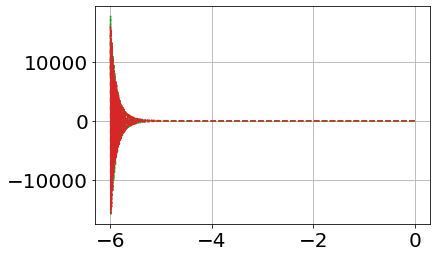

In [9]:
#warray = -np.logspace(np.log10(-wmesh[0]), np.log10(-wmesh[-1]), num=1000)

#Fpr_spline, Fpi_spline, Fnr_spline, Fni_spline = EH.tau_integral_trapped(0.047+1j*0.00119, warray, Tq_interp, z_spline, func=None, k=None, steps_per_period=100)
Fpr_spline, Fpi_spline, Fnr_spline, Fni_spline = EH.tau_integral_trapped(0.047+1j*0.00119, warray, lgTq_interp, z_spline, func='MCAk', k=0.0068, steps_per_period=100)

t_norm = np.linspace(0, 0.01, num=100)

# Fp = Fpr_spline.__call__(t_norm, lgw) + 1j * Fpi_spline.__call__(t_norm, lgw)
# Fn = Fnr_spline.__call__(t_norm, lgw) + 1j * Fni_spline.__call__(t_norm, lgw)

# fig, ax = plt.subplots(1,1, figsize=(10,8))
# plt.contourf(t_norm, -lgw, np.real(Fp).T)
# plt.grid()
# plt.show()

# fig, ax = plt.subplots(1,1, figsize=(10,8))
# plt.contourf(t_norm, -lgw, np.imag(Fp).T)
# plt.grid()
# plt.show()

# fig, ax = plt.subplots(1,1, figsize=(10,8))
# plt.contourf(t_norm, -lgw, np.real(Fn).T)
# plt.grid()
# plt.show()

# fig, ax = plt.subplots(1,1, figsize=(10,8))
# plt.contourf(t_norm, -lgw, np.imag(Fn).T)
# plt.grid()
# plt.show()

Fp = Fpr_spline.ev(np.ones_like(lgw), lgw) + 1j * Fpi_spline.ev(np.ones_like(lgw), lgw)
Fn = Fnr_spline.ev(np.ones_like(lgw), lgw) + 1j * Fni_spline.ev(np.ones_like(lgw), lgw)
plt.plot(-lgw, np.imag(Fp), '--')
plt.plot(-lgw, np.real(Fp), '--')
plt.plot(-lgw, np.imag(Fn), '--')
plt.plot(-lgw, np.real(Fn), '--')
# plt.ylim([-1, 1])
# plt.xlim([-4, 0])
plt.grid()
plt.show()

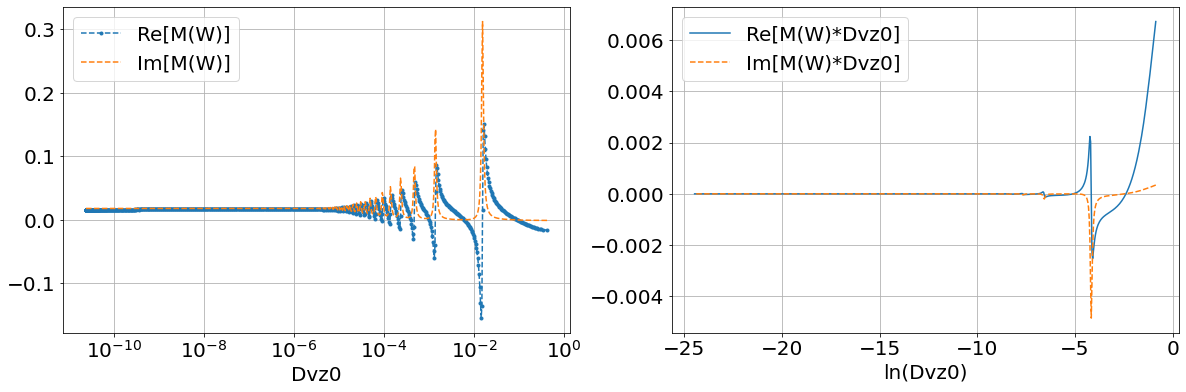

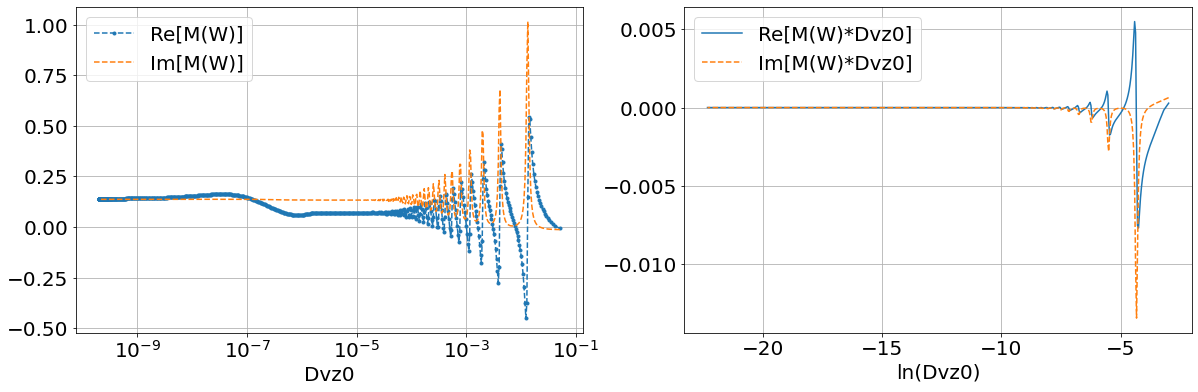

In [561]:
z0 = 1 #5.66
res = EH.energy_integral_trapped(z0, Tq_interp, tau_spline, z_spline, Fpr_spline, Fpi_spline, Fnr_spline, Fni_spline)

vz0 = np.sqrt(2*(res[1]+EH.potential(z0)))
Dvz0 = np.sqrt(2*EH.potential(z0)) - vz0


fig, ax = plt.subplots(1,2, figsize=(20,6))
ax[0].semilogx(Dvz0, np.real(res[2]), label='Re[M(W)]', linestyle='--', marker='.') #-res[1]/EH.height
ax[0].semilogx(Dvz0, np.imag(res[2]), label='Im[M(W)]', linestyle='--')
ax[0].set_xlabel('Dvz0')
ax[0].legend()
ax[0].grid()
#ax[0].set_title('z0=1, Delta=4, Psi=0.1, omega=0.047+0.00119j')

ax[1].plot(np.log(Dvz0), -np.real(res[2])*Dvz0, label='Re[M(W)*Dvz0]')
ax[1].plot(np.log(Dvz0), -np.imag(res[2])*Dvz0, label='Im[M(W)*Dvz0]', linestyle='--')
ax[1].set_xlabel('ln(Dvz0)')
#ax[1].set_title('z0=1, Delta=4, Psi=0.1, omega=0.047+0.00119j')
plt.legend()
plt.grid()
plt.show()

#print(np.trapz(res[2]*Dvz0, np.log(Dvz0)))



z0 = 7 #5.66

res = EH.energy_integral_trapped(z0, Tq_interp, tau_spline, z_spline, Fpr_spline, Fpi_spline, Fnr_spline, Fni_spline)

vz0 = np.sqrt(2*(res[1]+EH.potential(z0)))
Dvz0 = np.sqrt(2*EH.potential(z0)) - vz0

fig, ax = plt.subplots(1,2, figsize=(20,6))
ax[0].semilogx(Dvz0, np.real(res[2]), label='Re[M(W)]', linestyle='--', marker='.') #-res[1]/EH.height
ax[0].semilogx(Dvz0, np.imag(res[2]), label='Im[M(W)]', linestyle='--')
ax[0].set_xlabel('Dvz0')
ax[0].legend()
ax[0].grid()
#ax[0].set_title('z0=1, Delta=4, Psi=0.1, omega=0.047+0.00119j')

ax[1].plot(np.log(Dvz0), -np.real(res[2])*Dvz0, label='Re[M(W)*Dvz0]')
ax[1].plot(np.log(Dvz0), -np.imag(res[2])*Dvz0, label='Im[M(W)*Dvz0]', linestyle='--')
ax[1].set_xlabel('ln(Dvz0)')
#ax[1].set_title('z0=1, Delta=4, Psi=0.1, omega=0.047+0.00119j')
plt.legend()
plt.grid()
plt.show()

#print(np.trapz(res[2]*Dvz0, np.log(Dvz0)))

In [565]:
z0 = np.linspace(0.1, 12, num=100)
res = [EH.energy_integral_trapped(z0i, Tq_interp, tau_spline, z_spline, Fpr_spline, Fpi_spline, Fnr_spline, Fni_spline)[0] for z0i in z0]


tau_spline_trapped, wmax = EH.logtau_trapped(wnum=5000, znum=6000)
It_ref = [EH.orbit_integral_trapped(z0i, omega=omega, tau_spline_trapped=tau_spline_trapped, wmax=wmax, func='MCAk', k=0.0068, lgvzmin=-15, wnum=2000, zmaxmin=1e-9, zturn=5e-3, znum=800) for z0i in z0]

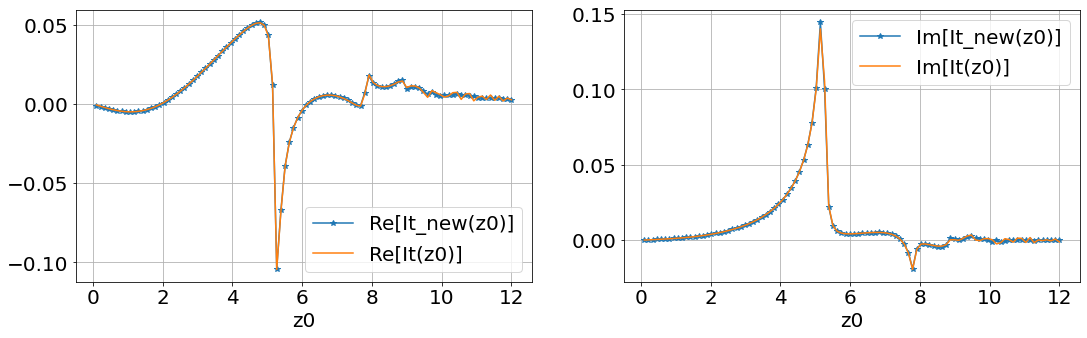

In [568]:
fig, ax = plt.subplots(1,2, figsize=(18,5))

ax[0].plot(z0, np.real(res), marker='*', label='Re[It_new(z0)]')
ax[0].plot(z0, np.real(It_ref), label='Re[It(z0)]')
ax[0].legend()
ax[0].grid()
ax[0].set_xlabel('z0')
ax[1].plot(z0, np.imag(res), marker='*', label='Im[It_new(z0)]')
ax[1].plot(z0, np.imag(It_ref), label='Im[It(z0)]')
ax[1].set_xlabel('z0')
ax[1].legend()
ax[1].grid()
plt.show()

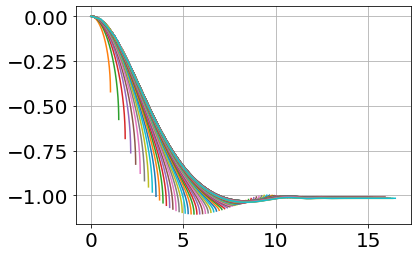

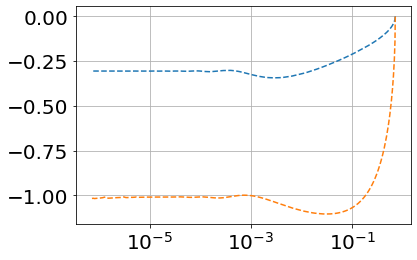

In [272]:
# for re in res:
for k in np.arange(0, 1000, 10):
    plt.plot(res[k][0], np.real(res[k][1]))
    #plt.plot(res[k][0], np.imag(res[k][1]))
# plt.plot(res[k][0][800:], np.real(res[k][1][800:]), '.')
# plt.plot(res[k][0][800:], np.real(res[k][2][800:]), '.')
#plt.plot(res[k][0][1000:], np.imag(res[k][1][1000:]))
# plt.plot(np.real(res[k][1][1000:]))
# plt.plot(np.imag(res[k][1][1000:]))
plt.grid()
plt.show()


plt.semilogx(-warray, np.imag([re[1][-1] for re in res]), '--')
plt.semilogx(-warray, np.real([re[1][-1] for re in res]), '--')
plt.grid()
plt.show()

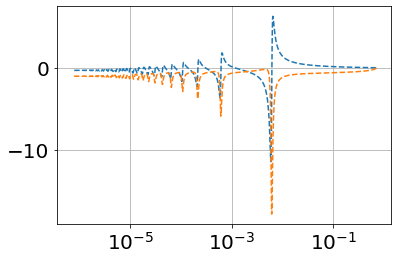

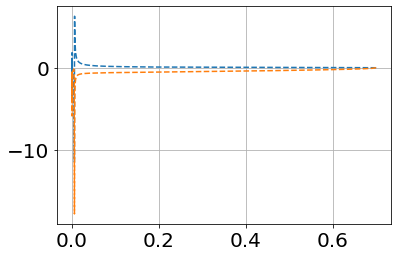

In [265]:
omega = 0.047 + 1j*0.00119
plt.semilogx(-warray, np.imag([re[1][-1] for re in res]/(1+np.exp(1j*2*omega*np.interp(warray, wmesh, Tq)))), '--')
plt.semilogx(-warray, np.real([re[1][-1] for re in res]/(1+np.exp(1j*2*omega*np.interp(warray, wmesh, Tq)))), '--')
plt.grid()
plt.show()

plt.plot(-warray, np.imag([re[1][-1] for re in res]/(1+np.exp(1j*2*omega*np.interp(warray, wmesh, Tq)))), '--')
plt.plot(-warray, np.real([re[1][-1] for re in res]/(1+np.exp(1j*2*omega*np.interp(warray, wmesh, Tq)))), '--')
#plt.xlim([0, 0.02])
plt.grid()
plt.show()

# Convergence studies
## 1. Function: orbit_integral_passing_discrete
parameters studied:              <ol>
<li>wnum(number of discretization points in energy) of the method 'logtau_passing'</li>
<li>znum(number of discretization points in space(or tau in equivalence)) of the method 'logtau_passing'</li>
<li>wmax(upper bound for the energy-integral) of the method 'logtau_passing'</li>
<li>wnum of the method 'orbit_integral_passing_discrete'</li>
<li>znum of the method 'orbit_integral_passing_discrete'</li>
</ol>
<br>
In order to get error less than 0.001, the least requirements are 
<li>logtau_passing.wnum=4000</li>
<li>logtau_passing.znum=1000,</li>
<li>logtau_passing.wmax=8,</li>
<li>orbit_integral_passing_discrete=600,</li>
<li>orbit_integral_passing_discrete.znum=120. </li>
It's not expensive computationally.

0:02:10.012004
error taking the least required resolution parameters=0.0009303365218556875
0:00:02.646010
wnum=1000, error=0.007984266661022277
wnum=2000, error=0.002924618564327255
wnum=3000, error=0.00147197841261112
wnum=4000, error=0.0008563852901296949
wnum=5000, error=0.0005468879357053841
wnum=6000, error=0.0003798299265451164
wnum=7000, error=0.00029073260227086435
wnum=8000, error=0.00024764628947746643
wnum=9000, error=0.0002310316446578219


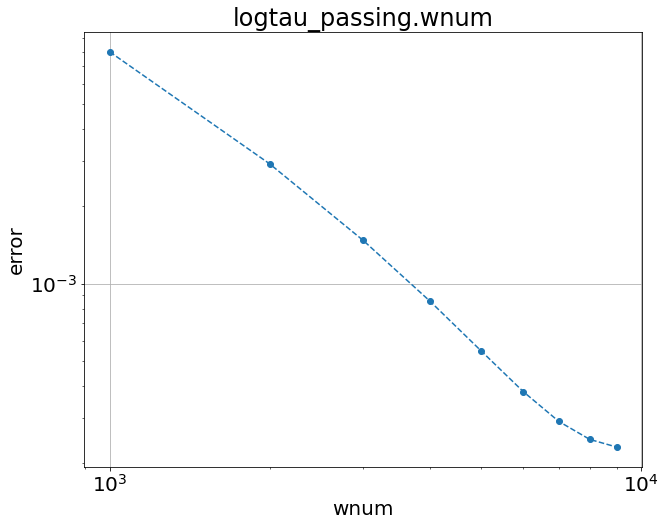

znum=1000, error=0.0005531775092363772
znum=2000, error=0.0005468879357053841
znum=3000, error=0.0005456636834879064
znum=4000, error=0.0005452487574920891
znum=5000, error=0.0005450586540869859
znum=6000, error=0.0005449547435705765
znum=7000, error=0.000544892584275972
znum=8000, error=0.0005448535699275826
znum=9000, error=0.0005448247498764441


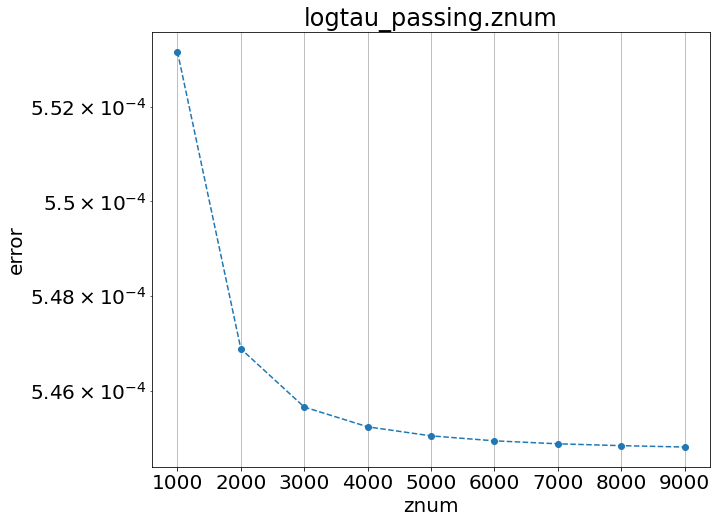

wnum=1, error=0.1480563838431563
wnum=2, error=0.0441211711151687
wnum=3, error=0.015645545803159997
wnum=4, error=0.005991438755475742
wnum=5, error=0.0023719957596780744
wnum=6, error=0.0009537703948547986
wnum=7, error=0.0005101748115124989
wnum=8, error=0.0005468879357053841
wnum=9, error=0.0006941522971566269
wnum=10, error=0.0008580750528715046


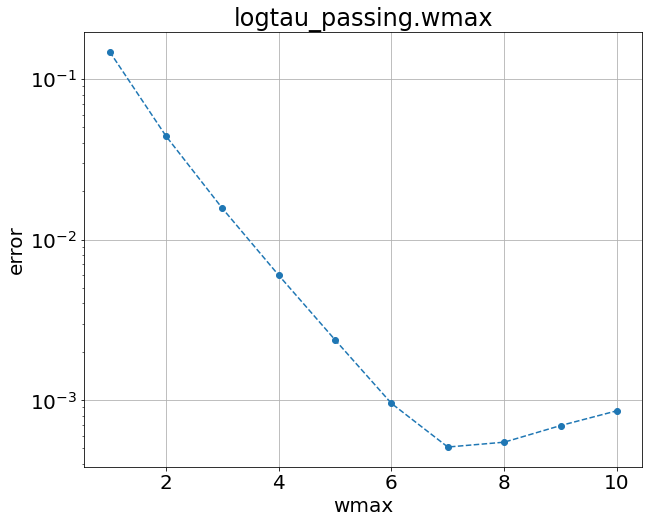

wnum=100, error=0.1642198133961217
wnum=200, error=0.03964688135494166
wnum=300, error=0.009866152738629945
wnum=400, error=0.0026970289488362042
wnum=500, error=0.0010912905265166532
wnum=600, error=0.0008580750528715046
wnum=700, error=0.0008353953942039643
wnum=800, error=0.0008324800559055576
wnum=900, error=0.0008318874378333513


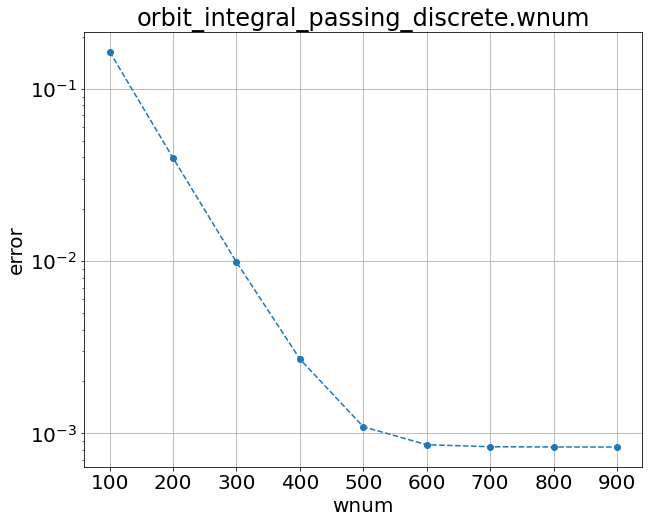

znum=10, error=0.5984494487766735
znum=30, error=0.005838906847705011
znum=50, error=0.002096694242851183
znum=70, error=0.0014214133705221226
znum=90, error=0.001035038971785189
znum=110, error=0.0009464028132476314
znum=130, error=0.0009076454072455321
znum=150, error=0.0008867053934303542
znum=170, error=0.0008782738077896271
znum=190, error=0.0008694103929333934
znum=210, error=0.0008713816845186293


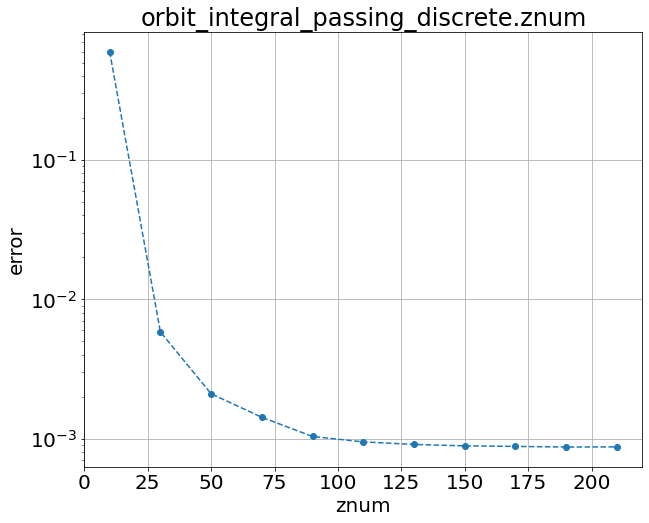

In [1315]:
omega = 0.047+0.00119j

EH = electronHole()
z0 = np.hstack([np.linspace(0, EH.hole_region, num=100, endpoint=False), np.linspace(EH.hole_region, 1000, num=300)])


tic = datetime.now()
tau_spline_passing, warray = EH.logtau_passing(lgwmin=1, lgwmax=9, lgwnum=9, wmin=1e-3, wmax=8, wnum=10000, znum=2000)
Ip_ref = np.array([EH.orbit_integral_passing_discrete(z0=z0i, omega=omega, tau_spline_passing=tau_spline_passing,
          warray=warray, func=None, wnum=4000, lgvzmin=-15, znum=1000) for z0i in z0])
print(datetime.now()-tic)


tic = datetime.now()
tau_spline_passing, warray = EH.logtau_passing(lgwmin=1, lgwmax=9, lgwnum=9, wmin=1e-3, wmax=8, wnum=4000, znum=1000)
Ip_lr = np.array([EH.orbit_integral_passing_discrete(z0=z0i, omega=omega, tau_spline_passing=tau_spline_passing,
          warray=warray, func=None, wnum=600, lgvzmin=-15, znum=120) for z0i in z0])
print(f'error taking the least required resolution parameters={np.linalg.norm(Ip_lr-Ip_ref)/np.linalg.norm(Ip_ref)}')
print(datetime.now()-tic)

#-----------------------------------------------------------
#study on the parameter 'wnum' of the method 'logtau_passing'
#-----------------------------------------------------------
wnums = np.arange(1000,10000, 1000)
errs = []
for wnum in wnums:
    
    tau_spline_passing, warray = EH.logtau_passing(lgwmin=1, lgwmax=9, lgwnum=9, wmin=1e-3, wmax=8, wnum=wnum, znum=2000)
    Ip = np.array([EH.orbit_integral_passing_discrete(z0=z0i, omega=omega, tau_spline_passing=tau_spline_passing,
          warray=warray, func=None, wnum=600, lgvzmin=-15, znum=200) for z0i in z0])
    err = np.linalg.norm(Ip-Ip_ref)/np.linalg.norm(Ip_ref)
    errs.append(err)
    print(f'wnum={wnum}, error={err}')
    
fig, ax = plt.subplots(1,1, figsize=(10,8))
plt.loglog(wnums, errs, 'o--')
plt.xlabel('wnum')
plt.ylabel('error')
plt.title('logtau_passing.wnum')
plt.grid()
plt.show()


#-----------------------------------------------------------
#study on the parameter 'znum' of the method 'logtau_passing'
#-----------------------------------------------------------
znums = np.arange(1000,10000,1000)
errs = []

for znum in znums:
    tau_spline_passing, warray = EH.logtau_passing(lgwmin=1, lgwmax=9, lgwnum=9, wmin=1e-3, wmax=8, wnum=5000, znum=znum)
    Ip = np.array([EH.orbit_integral_passing_discrete(z0=z0i, omega=omega, tau_spline_passing=tau_spline_passing,
          warray=warray, func=None, wnum=600, lgvzmin=-15, znum=200) for z0i in z0])
    err = np.linalg.norm(Ip-Ip_ref)/np.linalg.norm(Ip_ref)
    errs.append(err)
    print(f'znum={znum}, error={err}')
    
fig, ax = plt.subplots(1,1, figsize=(10,8))
plt.semilogy(znums, errs, 'o--')
plt.xlabel('znum')
plt.ylabel('error')
plt.title('logtau_passing.znum')
plt.grid()
plt.show()


#-----------------------------------------------------------
#study on the parameter 'wmax' of the method 'logtau_passing'
#-----------------------------------------------------------
wmaxs = np.arange(1, 11, 1)  #wnums = [100, 200, 400, 800, 1600]
errs = []
for wmax in wmaxs:
    tau_spline_passing, warray = EH.logtau_passing(lgwmin=1, lgwmax=9, lgwnum=9, wmin=1e-3, wmax=wmax, wnum=5000, znum=2000)
    Ip = np.array([EH.orbit_integral_passing_discrete(z0=z0i, omega=omega, tau_spline_passing=tau_spline_passing, 
          warray=warray, func=None, wnum=600, lgvzmin=-15, znum=200) for z0i in z0])
    err = np.linalg.norm(Ip-Ip_ref)/np.linalg.norm(Ip_ref)
    errs.append(err)
    print(f'wnum={wmax}, error={err}')
    
fig, ax = plt.subplots(1,1, figsize=(10,8))
plt.semilogy(wmaxs, errs, 'o--')
plt.xlabel('wmax')
plt.ylabel('error')
plt.title('logtau_passing.wmax')
plt.grid()
plt.show()


#------------------------------------------------------------------------------
#study on the parameter 'wnum' of the method 'orbit_integral_passing_discrete'
#------------------------------------------------------------------------------
wnums = np.arange(100, 1000, 100)  #wnums = [100, 200, 400, 800, 1600]
errs = []
for wnum in wnums:
    Ip = np.array([EH.orbit_integral_passing_discrete(z0=z0i, omega=omega, tau_spline_passing=tau_spline_passing, 
          warray=warray, func=None, wnum=wnum, lgvzmin=-15, znum=200) for z0i in z0])
    err = np.linalg.norm(Ip-Ip_ref)/np.linalg.norm(Ip_ref)
    errs.append(err)
    print(f'wnum={wnum}, error={err}')
    
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1,1, figsize=(10,8))
plt.semilogy(wnums, errs, 'o--')
plt.xlabel('wnum')
plt.ylabel('error')
plt.title('orbit_integral_passing_discrete.wnum')
plt.grid()
plt.show()


#------------------------------------------------------------------------------
#study on the parameter 'znum' of the method 'orbit_integral_passing_discrete'
#------------------------------------------------------------------------------
znums = np.arange(10, 220, 20) #[10, 20100, 200, 400, 800, 1600]
errs = []
for znum in znums:
    Ip = np.array([EH.orbit_integral_passing_discrete(z0=z0i, omega=omega, tau_spline_passing=tau_spline_passing,
          warray=warray, func=None, wnum=600, lgvzmin=-15, znum=znum) for z0i in z0])
    err = np.linalg.norm(Ip-Ip_ref)/np.linalg.norm(Ip_ref)
    errs.append(err)
    print(f'znum={znum}, error={err}')
    
fig, ax = plt.subplots(1,1, figsize=(10,8))   
plt.semilogy(znums, errs, 'o--')
plt.xlabel('znum')
plt.ylabel('error')
plt.title('orbit_integral_passing_discrete.znum')
plt.grid()
plt.show()

## 2. Function: orbit_integral_trapped
parameters studied:              <ol>
<li>wnum(number of discretization points in energy) of the method 'logtau_trapped'</li>
<li>znum(number of discretization points in space(or tau in equivalence)) of the method 'logtau_trapped'</li>
<li>zturn(portion of the trajectory around the turning point that are treated specially due to zero velocity there) of the method 'orbit_integral_trapped'</li>
<li>wnum of the method 'orbit_integral_trapped'</li>
<li>znum of the method 'orbit_integral_trapped'</li>
</ol>
<br>
In order to get error less than 0.001, the least requirements are 
<li>logtau_trapped.wnum=4000</li>
<li>logtau_trapped.znum=3000,</li>
<li>orbit_integral_trapped.zturn=0.01,</li>
<li>orbit_integral_trapped.wnum=300. </li>
<li>orbit_integral_trapped.znum=200,</li>
It's also not expensive computationally.

0:01:14.808236
error taking the least required resolution parameters=0.0009280825474492063
0:00:04.952855
wnum=1000, error=0.007570079924953122
wnum=2000, error=0.00260900989159906
wnum=3000, error=0.0011610956913304074
wnum=4000, error=0.0006091239850915121


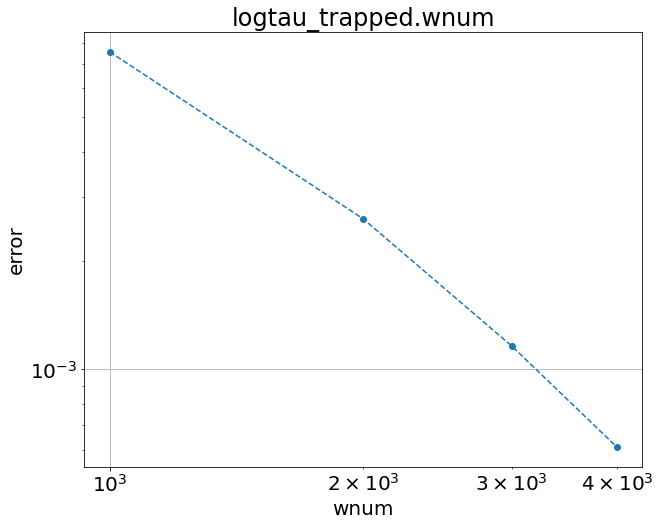

znum=1000, error=0.0025124236289141
znum=2000, error=0.001395395973154772
znum=3000, error=0.0009468537242360398
znum=4000, error=0.0007048973961745303
znum=5000, error=0.0005654717479156462


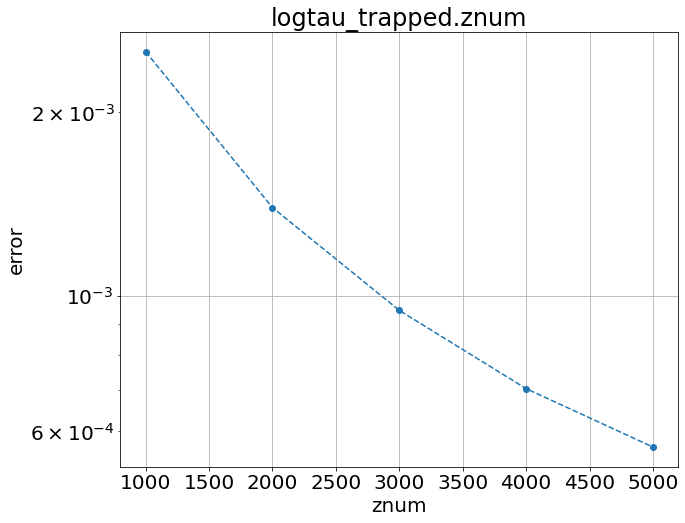

zturn=0.1, error=0.013018523799470815
zturn=0.05, error=0.00466045964040744
zturn=0.02, error=0.0011416055585146368
zturn=0.01, error=0.0005654717479156462
zturn=0.005, error=0.0014948672009309296
zturn=0.002, error=0.0053892865707123455
zturn=0.001, error=0.012328397834937166
zturn=0.0001, error=0.09376172816209381
zturn=1e-05, error=0.3945996881128928
zturn=1e-06, error=1.3651736766485751
zturn=1e-07, error=4.441103760798371


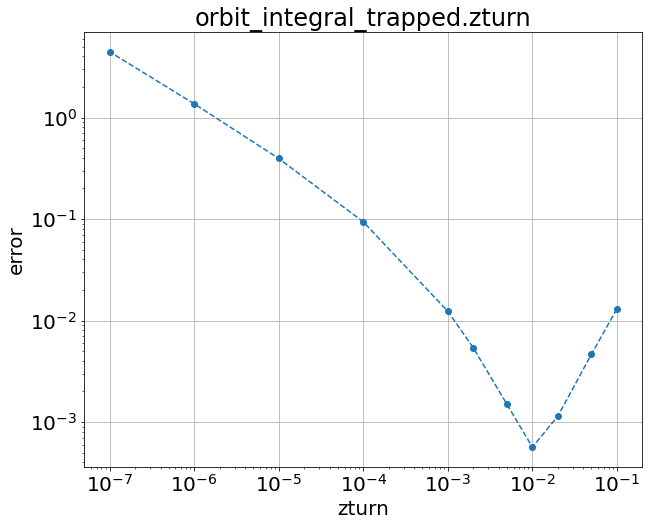

wnum=100, error=0.02655269969543713
wnum=200, error=0.001970488596211112
wnum=300, error=0.0005654717479156462
wnum=400, error=0.00048278636842810716
wnum=500, error=0.0004519707445111332
wnum=600, error=0.0004383983427854894
wnum=700, error=0.00043185928189642513
wnum=800, error=0.00042722562675090187
wnum=900, error=0.00042452219580781775


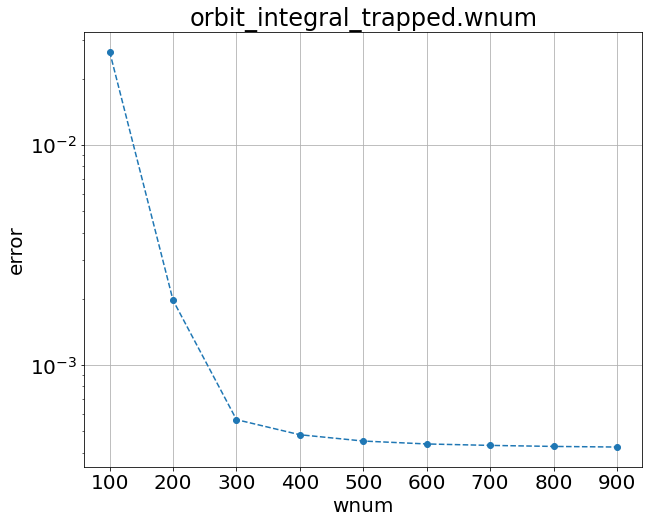

znum=100, error=0.0019781778513623775
znum=200, error=0.0005654717479156462
znum=300, error=0.00048684354483137255
znum=400, error=0.0005048627277693915
znum=500, error=0.0005211230745765809
znum=600, error=0.0005318791846697986
znum=700, error=0.0005389759383307467
znum=800, error=0.0005438113409456964
znum=900, error=0.0005472500228665585


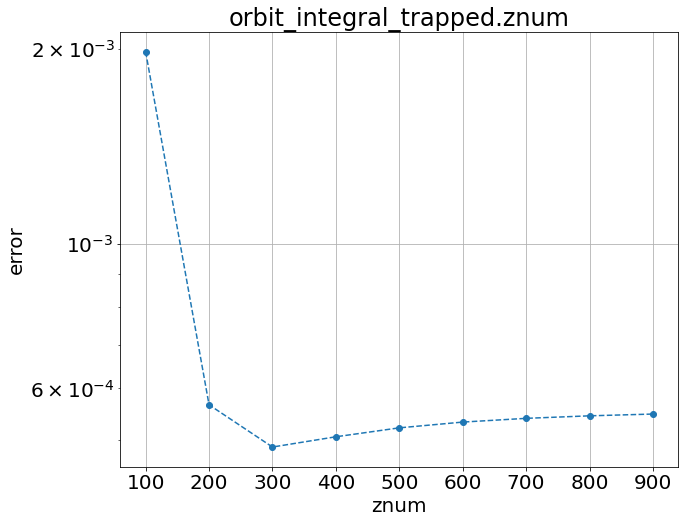

In [1318]:
EH = electronHole()

z0 = np.hstack([np.linspace(0, EH.hole_region, num=100, endpoint=False), np.linspace(EH.hole_region, 1000, num=300)])


tic = datetime.now()
tau_spline_trapped, wmax = EH.logtau_trapped(wnum=5000, znum=6000)
It_ref = np.array([EH.orbit_integral_trapped(z0=z0i, omega=omega, tau_spline_trapped=tau_spline_trapped,
          wmax=wmax, func=None, lgvzmin=-15, wnum=2000, zmaxmin=1e-9, zturn=5e-3, znum=800) for z0i in z0])
print(datetime.now()-tic)


tic = datetime.now()
tau_spline_trapped, wmax = EH.logtau_trapped(wnum=4000, znum=3000)
It_lr = np.array([EH.orbit_integral_trapped(z0=z0i, omega=omega, tau_spline_trapped=tau_spline_trapped,
          wmax=wmax, func=None, lgvzmin=-15, wnum=400, zmaxmin=1e-9, zturn=1e-2, znum=200) for z0i in z0])
print(f'error taking the least required resolution parameters={np.linalg.norm(It_lr-It_ref)/np.linalg.norm(It_ref)}')
print(datetime.now()-tic)


#-------------------------------------------------------
#study on 'wnum' of the method 'logtau_trapped'
#-------------------------------------------------------
wnums = np.arange(1000,5000, 1000)
errs = []
for wnum in wnums:
    tau_spline_trapped, wmax = EH.logtau_trapped(wnum=wnum, znum=6000)
    It = np.array([EH.orbit_integral_trapped(z0=z0i, omega=omega, tau_spline_trapped=tau_spline_trapped, 
          wmax=wmax, func=None, lgvzmin=-15, wnum=300, zmaxmin=1e-9, zturn=1e-2, znum=200) for z0i in z0])
    #err = np.trapz(EH.dpdz(z0)*It,z0)/np.trapz(EH.dpdz(z0)**2,z0) #eigenvalue (the contribution form the trapped particles)
    err = np.linalg.norm(It-It_ref)/np.linalg.norm(It_ref)
    errs.append(err)
    print(f'wnum={wnum}, error={err}')
    
fig, ax = plt.subplots(1,1, figsize=(10,8))
plt.loglog(wnums, errs, 'o--')
plt.xlabel('wnum')
plt.ylabel('error')
plt.title('logtau_trapped.wnum')
plt.grid()
plt.show()



#-------------------------------------------------------
#study on 'znum' of the method 'logtau_trapped'
#-------------------------------------------------------
znums = np.arange(1000,6000,1000)
errs = []
for znum in znums:
    tau_spline_trapped, wmax = EH.logtau_trapped(wnum=5000, znum=znum)
    It = np.array([EH.orbit_integral_trapped(z0=z0i, omega=omega, tau_spline_trapped=tau_spline_trapped, 
          wmax=wmax, func=None, lgvzmin=-15, wnum=300, zmaxmin=1e-9, zturn=1e-2, znum=200) for z0i in z0])
    err = np.linalg.norm(It-It_ref)/np.linalg.norm(It_ref)
    errs.append(err)
    print(f'znum={znum}, error={err}')
    
plt.rcParams.update({'font.size': 20})    
fig, ax = plt.subplots(1,1, figsize=(10,8))
plt.semilogy(znums, errs, 'o--')
plt.xlabel('znum')
plt.ylabel('error')
plt.title('logtau_trapped.znum')
plt.grid()
plt.show()


#-------------------------------------------------------
#study on 'zturn' of the method 'orbit_integral_trapped'
#-------------------------------------------------------
zturns = [1e-1, 5e-2, 2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
errs = []
for zt in zturns:
    It = np.array([EH.orbit_integral_trapped(z0=z0i, omega=omega, tau_spline_trapped=tau_spline_trapped, 
          wmax=wmax, func=None, lgvzmin=-15, wnum=300, zmaxmin=1e-9, zturn=zt, znum=200) for z0i in z0])
    err = np.linalg.norm(It-It_ref)/np.linalg.norm(It_ref)
    errs.append(err)
    print(f'zturn={zt}, error={err}')
    
fig, ax = plt.subplots(1,1, figsize=(10,8))
plt.loglog(zturns, errs, 'o--')
plt.xlabel('zturn')
plt.ylabel('error')
plt.title('orbit_integral_trapped.zturn')
plt.grid()
plt.show()


#-------------------------------------------------------
#study on 'wnum' of the method 'orbit_integral_trapped'
#-------------------------------------------------------
wnums = np.arange(100,1000,100)
errs = []
for wnum in wnums:
    It = np.array([EH.orbit_integral_trapped(z0=z0i, omega=omega, tau_spline_trapped=tau_spline_trapped, 
          wmax=wmax, func=None, lgvzmin=-15, wnum=wnum, zmaxmin=1e-9, zturn=1e-2, znum=200) for z0i in z0])
    err = np.linalg.norm(It-It_ref)/np.linalg.norm(It_ref)
    errs.append(err)
    print(f'wnum={wnum}, error={err}')
    
fig, ax = plt.subplots(1, 1, figsize=(10,8))
plt.semilogy(wnums, errs, 'o--')
plt.xlabel('wnum')
plt.ylabel('error')
plt.title('orbit_integral_trapped.wnum')
plt.grid()
plt.show()


#-------------------------------------------------------
#study on 'znum' of the method 'orbit_integral_trapped'
#-------------------------------------------------------
znums = np.arange(100,1000,100)
errs = []
for znum in znums:
    It = np.array([EH.orbit_integral_trapped(z0=z0i, omega=omega, tau_spline_trapped=tau_spline_trapped, 
          wmax=wmax, func=None, lgvzmin=-15, wnum=300, zmaxmin=1e-9, zturn=1e-2, znum=znum) for z0i in z0])
    err = np.linalg.norm(It-It_ref)/np.linalg.norm(It_ref)
    errs.append(err)
    print(f'znum={znum}, error={err}')
    
fig, ax = plt.subplots(1,1, figsize=(10,8))
plt.semilogy(znums, errs, 'o--')
plt.xlabel('znum')
plt.ylabel('error')
plt.title('orbit_integral_trapped.znum')
plt.grid()
plt.show()

# study on hole_region
the potential is nonzero inside the hole_region, and zero outside of the hole_region.

<li>The optimal hole_region is about 5~8. </li>
<li>hole_region too small, not a good approximation for the hole potential;</li>
<li>hole_region too large, the accuracy decreases as well because the spacing increases as 'znum' is fixed.</li>

hole_region/width=1.0, error=0.7020185304261807
hole_region/width=1.4, error=0.5239564076253138
hole_region/width=1.9, error=0.2525644498395634
hole_region/width=2.4, error=0.05317002207969831
hole_region/width=2.8, error=0.010756503581220881
hole_region/width=3.2, error=0.002489639090219029
hole_region/width=3.7, error=0.0012828432734749973
hole_region/width=4.2, error=0.001185686425287679
hole_region/width=4.6, error=0.0010726613188316153
hole_region/width=5.0, error=0.0009793753700842543
hole_region/width=5.5, error=0.0009252320067630764
hole_region/width=6.0, error=0.0009005373762432386
hole_region/width=6.4, error=0.000892272154251294
hole_region/width=6.8, error=0.0008984673716960156
hole_region/width=7.3, error=0.0009045296613773116
hole_region/width=7.8, error=0.0009430668468266965
hole_region/width=8.2, error=0.0009642416552678557
hole_region/width=8.6, error=0.0009586987122225379
hole_region/width=9.1, error=0.000987644549545437
hole_region/width=9.6, error=0.0010054905093843

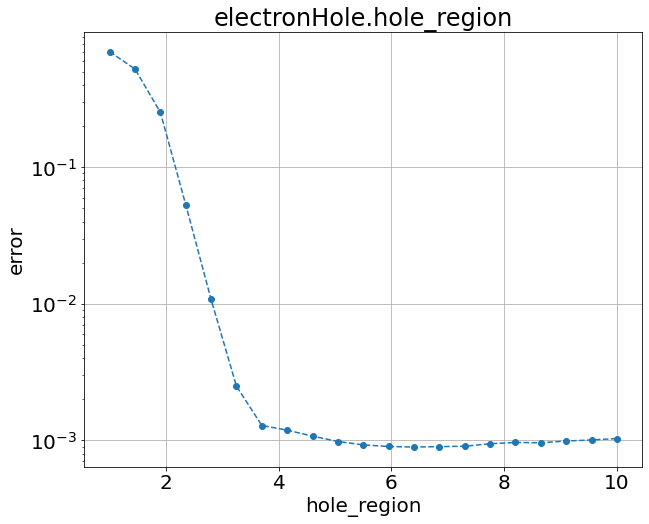

In [1321]:
hrs = np.linspace(1, 10, num=21)
errs = []

for hr in hrs:
    
    EH = electronHole(hole_region_over_width=hr)
    
    tau_spline_passing, warray = EH.logtau_passing(lgwmin=1, lgwmax=9, lgwnum=9, wmin=1e-3, wmax=8, wnum=4000, znum=1000)

    Ip = np.array([EH.orbit_integral_passing_discrete(z0=z0i, omega=omega, tau_spline_passing=tau_spline_passing,
          warray=warray, func=None, wnum=600, lgvzmin=-15, znum=200) for z0i in z0])

    tau_spline_trapped, wmax = EH.logtau_trapped(wnum=4000, znum=5000)
    
    It = np.array([EH.orbit_integral_trapped(z0=z0i, omega=omega, tau_spline_trapped=tau_spline_trapped, 
          wmax=wmax, func=None, k=None, lgvzmin=-15, wnum=300, zmaxmin=1e-9, zturn=1e-2, znum=200) for z0i in z0])
    
    err = np.linalg.norm(Ip+It-Ip_ref-It_ref)/np.linalg.norm(Ip_ref+It_ref)
    
    errs.append(err)
    
    print(f'hole_region/width={np.round(hr,1)}, error={err}')

fig, ax = plt.subplots(1,1, figsize=(10,8))
plt.semilogy(hrs, errs, 'o--')
plt.xlabel('hole_region')
plt.ylabel('error')
plt.title('electronHole.hole_region')
plt.grid()
plt.show()

# Function MC
MC = \int_k dk * MCAk(k,z0)*MCAk(k,z)/Gamma(k). The integral over k is divided into 5 sub-integrals in 5 different k-ranges using different k-resolutions:
<li>[-kin*kres-kstep*kperiod[1], -kin*kres-kstep*kperiod[0]], num=knum[0]+1,</li>
<li>[-kin*kres-kstep*kperiod[0], -kin*kres], num=knum[1]+1,</li>
<li>[-kin*kres, kin*kres], num=knum[2]+1,</li>
<li>[kin*kres, kin*kres+kstep*kperiod[0]], num=knum[1]+1,</li>
<li>[kin*kres+kstep*kperiod[0], kin*kres+kstep*kperiod[1]], num=knum[0]+1</li>

where kres=kperp*omega is the resonance wavenumber, kstep=2*pi/|z-z0| is the wavenumber of MC when k -> infty.

<br>
The parameters studied are:
<li>kin, which determines the upper and lower of the range that kres lives in;</li>
<li>kperiod, which determines the upper(lower) bound for the intermediate and high k range;</li>
<li>knum, which determines the k-resolutions in each range;</li>
<br>
The optimal setting of parameters is kin=20, knum=(2000,2000,3000), kperiod=(100,1000).

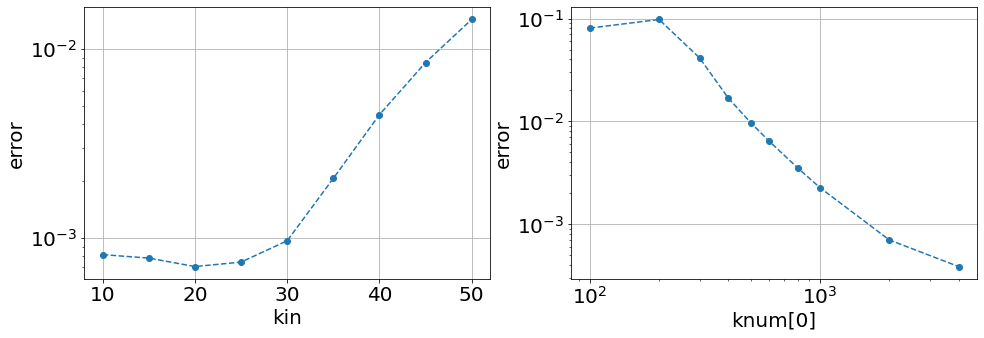

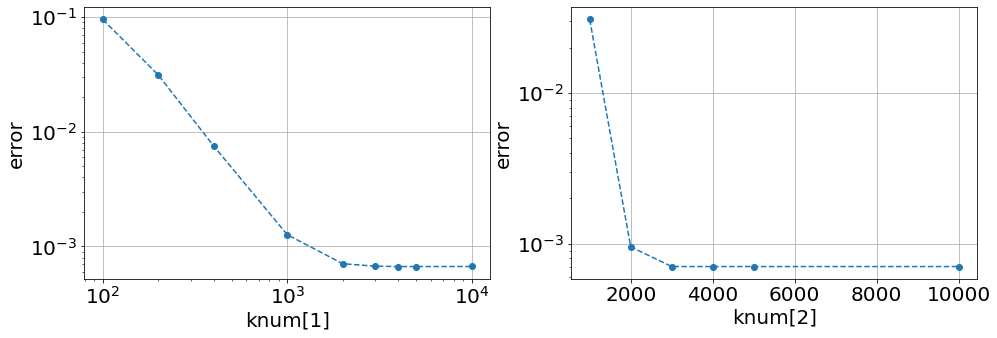

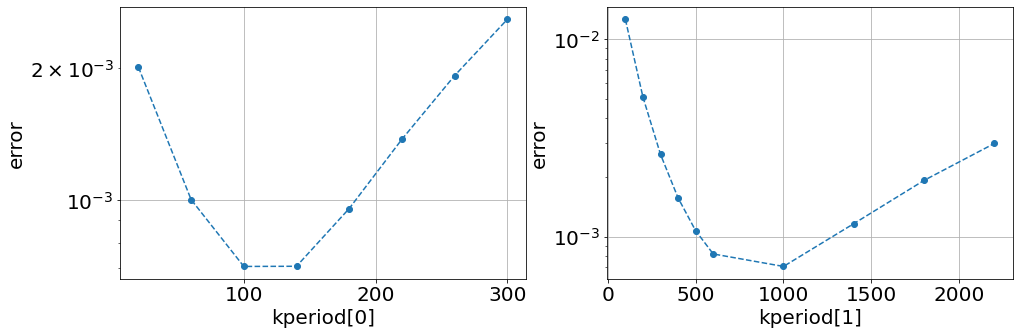

In [1353]:
z0 = np.linspace(0, 200, num=101)
z = 3
ref = np.array([EH.MC(z0=z0i, z=z, omega=omega, kp=0.143, kin=20, kperiod=(200,2000), knum=(20000, 20000, 60000)) for z0i in z0])


kins = [10, 15, 20, 25, 30, 35, 40, 45, 50]
errs = []
for kin in kins:
    err = np.linalg.norm(np.array([EH.MC(z0=z0i, z=z, omega=omega, kp=0.143, kin=kin, kperiod=(100,1000), knum=(2000, 2000, 3000)) for z0i in z0])-ref)/np.linalg.norm(ref)
    errs.append(err)
    
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].semilogy(kins, errs, '--o')
ax[0].set_xlabel('kin')
ax[0].set_ylabel('error')
ax[0].grid()


knums = [100, 200, 300, 400, 500, 600, 800, 1000, 2000, 4000]
errs = []
for knum in knums:
    err = np.linalg.norm(np.array([EH.MC(z0=z0i, z=z, omega=omega, kp=0.143, kin=20, kperiod=(100,1000), knum=(knum, 2000, 3000)) for z0i in z0])-ref)/np.linalg.norm(ref)
    errs.append(err)
ax[1].loglog(knums, errs, '--o')
ax[1].set_xlabel('knum[0]')
ax[1].set_ylabel('error')
plt.grid()
plt.show()

knums = [100, 200, 400, 1000, 2000, 3000, 4000, 5000, 10000]
errs = []
for knum in knums:
    err = np.linalg.norm(np.array([EH.MC(z0=z0i, z=z, omega=omega, kp=0.143, kin=20, kperiod=(100,1000), knum=(2000, knum, 3000)) for z0i in z0])-ref)/np.linalg.norm(ref)
    errs.append(err)
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].loglog(knums, errs, '--o')
ax[0].set_xlabel('knum[1]')
ax[0].set_ylabel('error')
ax[0].grid()

knums = [1000, 2000, 3000, 4000, 5000, 10000]
errs = []
for knum in knums:
    err = np.linalg.norm(np.array([EH.MC(z0=z0i, z=z, omega=omega, kp=0.143, kin=20, kperiod=(100,1000), knum=(2000, 2000, knum)) for z0i in z0])-ref)/np.linalg.norm(ref)
    errs.append(err)
ax[1].semilogy(knums, errs, '--o')
ax[1].set_xlabel('knum[2]')
ax[1].set_ylabel('error')
ax[1].grid()
plt.show()


kperiods = np.arange(20, 320, 40) #[10, 20, 40, 60, 80, 100, 120, 140]
errs = []
for kper in kperiods:
    err = np.linalg.norm(np.array([EH.MC(z0=z0i, z=z, omega=omega, kp=0.143, kin=20, kperiod=(kper,1000), knum=(2000, 2000, 3000)) for z0i in z0])-ref)/np.linalg.norm(ref)
    errs.append(err)
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].semilogy(kperiods, errs, '--o')
ax[0].set_xlabel('kperiod[0]')
ax[0].set_ylabel('error')
ax[0].grid()

kperiods = [100, 200, 300, 400, 500, 600, 1000, 1400, 1800, 2200]
errs = []
for kper in kperiods:
    err = np.linalg.norm(np.array([EH.MC(z0=z0i, z=z, omega=omega, kp=0.143, kin=20, kperiod=(100,kper), knum=(2000, 2000, 3000)) for z0i in z0])-ref)/np.linalg.norm(ref)
    errs.append(err)
ax[1].semilogy(kperiods, errs, '--o')
ax[1].set_xlabel('kperiod[1]')
ax[1].set_ylabel('error')
ax[1].grid()
plt.show()


#res = EH.MC(z0=-1, z=20, omega=omega, kp=0.143, kin=20, kperiod=(200,200), knum=(1000, 1000, 2000))

In [1491]:
tic = datetime.now()

omega = 0.047+0.00119j

zp = np.hstack([np.linspace(0, EH.hole_region, num=200, endpoint=False), np.linspace(EH.hole_region, 5000, num=400)])

Mp_tot = []

for i in range(len(zp)):
    
    Mp = np.array([EH.MC(z0=zpi, z=zp[i], omega=omega, kp=0.143, kin=20, kperiod=(100,400), knum=(200, 1000, 2000)) for zpi in zp])
    
    Mp_tot.append(Mp)
    
print(datetime.now()-tic)

0:11:29.489116


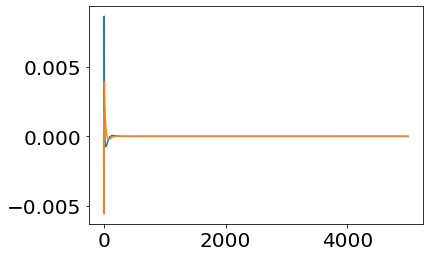

0:00:45.749503


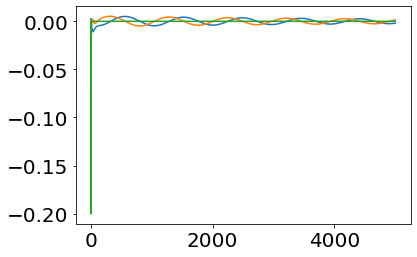

0:00:00.893305


In [1492]:
tic = datetime.now()

tau_spline_passing, warray = EH.logtau_passing(lgwmin=1, lgwmax=9, lgwnum=9, wmin=1e-3, wmax=8, wnum=6000, znum=2000)

tau_spline_trapped, wmax = EH.logtau_trapped(wnum=5000, znum=6000)

I4 = np.array([EH.orbit_integral_passing_discrete(z0=z0i, omega=omega, tau_spline_passing=tau_spline_passing,
          warray=warray, func=None, wnum=1000, lgvzmin=-15, znum=400) for z0i in zp])

I4 += np.array([EH.orbit_integral_trapped(z0=z0i, omega=omega, tau_spline_trapped=tau_spline_trapped,
          wmax=wmax, func=None, lgvzmin=-15, wnum=600, zmaxmin=1e-9, zturn=1e-2, znum=400) for z0i in zp])

plt.plot(zp, np.real(I4))
plt.plot(zp, np.imag(I4))
#plt.xlim([0, 250])
plt.show()

print(datetime.now()-tic)
tic = datetime.now()

M1 = np.trapz(EH.MD2(zp)*I4, zp) * EH.MD2(zp) / np.trapz(EH.MD2(zp)**2, zp) * 16 / (kp**2+12)

for i in range(len(zp)):
    M1[i] += np.trapz(np.conjugate(Mp_tot[i])*I4, zp)

plt.plot(zp, np.real(M1))
plt.plot(zp, np.imag(M1))
plt.plot(zp, EH.dpdz(zp))
#plt.xlim([0, 50])
plt.show()

print(datetime.now()-tic)

-1e-20
(-0.029708111320494654-0.01696957128942575j)
(0.29849744210753953+0.12099975964543971j)
(-0.006973502958129557+0.1475722297632871j)
(0.026079880786127902+0.19570299279375797j)
(-0.2632970871136263-0.18793388230814934j)
(-0.2141326695560429-0.20639317019772607j)


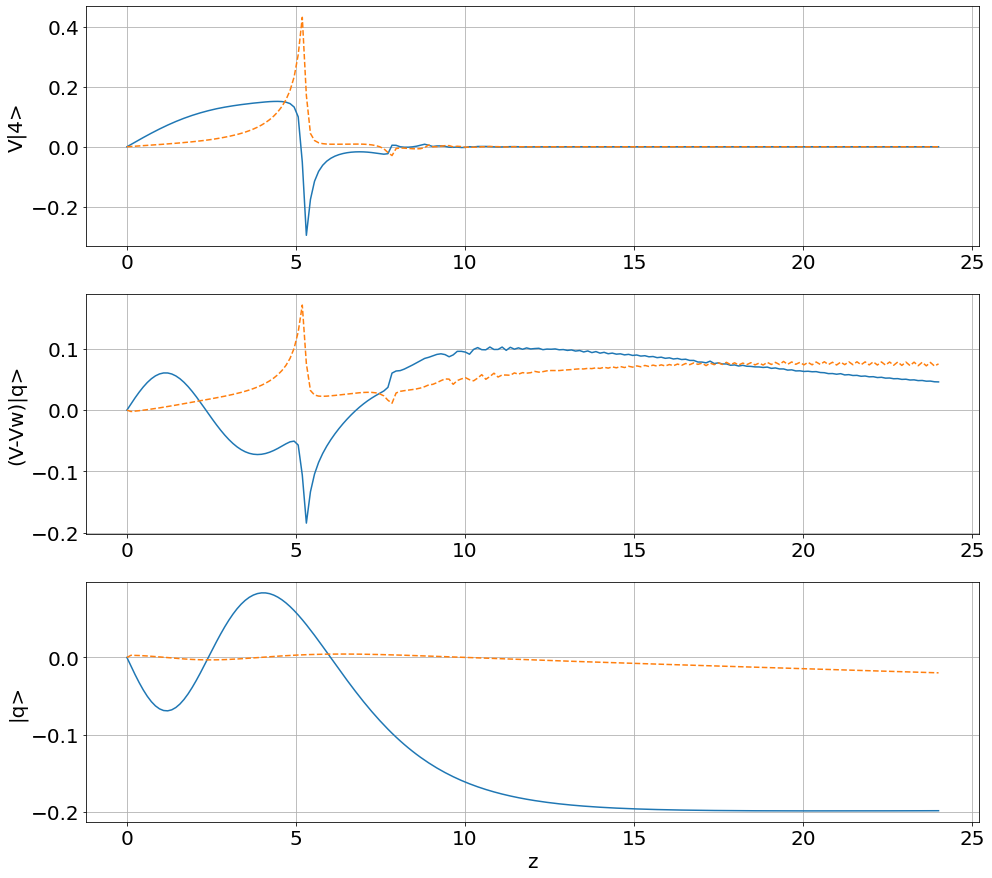

0:01:07.303498


In [444]:

tic = datetime.now()

EH = electronHole(height=0.1, hole_region_over_width=6)

omega = 0.047+0.00119j

#zp = np.hstack([np.linspace(0, EH.hole_region, num=200, endpoint=False), np.linspace(EH.hole_region, 50, num=100)])
zp = np.linspace(0, EH.hole_region, num=200)

tau_spline_passing, warray = EH.logtau_passing(lgwmin=1, lgwmax=9, lgwnum=9, wmin=1e-4, wmax=8, wnum=6000, znum=2000)

tau_spline_trapped, wmax = EH.logtau_trapped(wnum=2000, znum=6000)

print(wmax)


I4 = np.array([EH.orbit_integral_passing_discrete(z0=z0i, omega=omega, tau_spline_passing=tau_spline_passing,
          warray=warray, func='MD4', k=None, wnum=1800, lgvzmin=-15, znum=800) for z0i in zp])

print(np.trapz(EH.MD4(zp)*I4, zp)/ np.trapz(EH.MD4(zp)**2, zp))

I4 = np.array([EH.orbit_integral_trapped(z0=z0i, omega=omega, tau_spline_trapped=tau_spline_trapped,
          wmax=wmax, func='MD4', k=None, lgvzmin=-5, wnum=600, zmaxmin=1e-9, zturn=1e-2, znum=200) for z0i in zp])


I2 = np.array([EH.orbit_integral_passing_discrete(z0=z0i, omega=omega, tau_spline_passing=tau_spline_passing,
          warray=warray, func='MD2', k=None, wnum=600, lgvzmin=-15, znum=200) for z0i in zp])

I2 += np.array([EH.orbit_integral_trapped(z0=z0i, omega=omega, tau_spline_trapped=tau_spline_trapped,
          wmax=wmax, func='MD2', k=None, lgvzmin=-15, wnum=600, zmaxmin=1e-9, zturn=1e-2, znum=200) for z0i in zp])

print(np.trapz(EH.MD4(zp)*I4, zp)/np.trapz(EH.MD4(zp)**2, zp))

print(np.trapz(EH.MD4(zp)*I2, zp)/ np.sqrt(np.trapz(EH.MD4(zp)**2, zp)) / np.sqrt(np.trapz(EH.MD2(zp)**2, zp)) )

print(np.trapz(EH.MD2(zp)*I4, zp)/ np.sqrt(np.trapz(EH.MD4(zp)**2, zp)) / np.sqrt(np.trapz(EH.MD2(zp)**2, zp)) )


kp = 0.143
kwp = kp * EH.width * np.real(omega)

Iwp = np.array([EH.orbit_integral_passing_continuous(z0=zi, omega=omega, k=kwp, tau_spline_passing=tau_spline_passing, 
                                           warray=warray, wnum=600, lgvzmin=-16, znum=200) for zi in zp])
# Iwp = np.array([EH.orbit_integral_passing_discrete(z0=z0i, omega=omega, tau_spline_passing=tau_spline_passing,
#           warray=warray, func='MCAk', k=kwp, wnum=600, lgvzmin=-15, znum=200) for z0i in zp])

Iwp += np.array([EH.orbit_integral_trapped(z0=zi, omega=omega, tau_spline_trapped=tau_spline_trapped,
          wmax=wmax, func='MCAk', k=kwp, lgvzmin=-15, wnum=600, zmaxmin=1e-9, zturn=1e-2, znum=200) for zi in zp])

kwn = - kwp

Iwn = np.array([EH.orbit_integral_passing_continuous(z0=zi, omega=omega, k=kwn, tau_spline_passing=tau_spline_passing, 
                                           warray=warray, wnum=600, lgvzmin=-16, znum=200) for zi in zp])

# Iwn = np.array([EH.orbit_integral_passing_discrete(z0=z0i, omega=omega, tau_spline_passing=tau_spline_passing,
#           warray=warray, func='MCAk', k=kwn, wnum=600, lgvzmin=-15, znum=200) for z0i in zp])

Iwn += np.array([EH.orbit_integral_trapped(z0=zi, omega=omega, tau_spline_trapped=tau_spline_trapped,
          wmax=wmax, func='MCAk', k=kwn, lgvzmin=-15, wnum=600, zmaxmin=1e-9, zturn=1e-2, znum=200) for zi in zp])

print(np.trapz(EH.MCAk(kwn, zp)* Iwp, zp))
print(np.trapz(EH.MCAk(kwp, zp)*Iwn, zp))


plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(3,1, figsize=(16,15))
ax[0].plot(zp, np.real(I4))
ax[0].plot(zp, np.imag(I4), '--')
ax[0].grid()
ax[0].set_ylabel('V|4>')

ax[1].plot(zp, np.real(Iwp))
ax[1].plot(zp, np.imag(Iwp), '--')
ax[1].grid()
ax[1].set_ylabel('(V-Vw)|q>')

ax[2].plot(zp, np.real(EH.MCAk(kwp, zp)))
ax[2].plot(zp, np.imag(EH.MCAk(kwp, zp)), '--')
ax[2].grid()
ax[2].set_ylabel('|q>')

plt.xlabel('z')
plt.show()

print(datetime.now()-tic)

# (-0.0012894895588977443-0.00215898521927341j)
# (-0.0013197347619371507-0.0021672876102850265j)
# (0.399652561363246-0.3017985629179867j)
# (0.34043167841034155-0.25691758484912086j)

# (-0.0012993678452089335-0.0021515974793007045j)
# (-0.0013431847534875656-0.0021479983720340892j)
# (0.17637423331746466-0.763082153140611j)
# (0.19348549824991418-0.48844972070476617j)

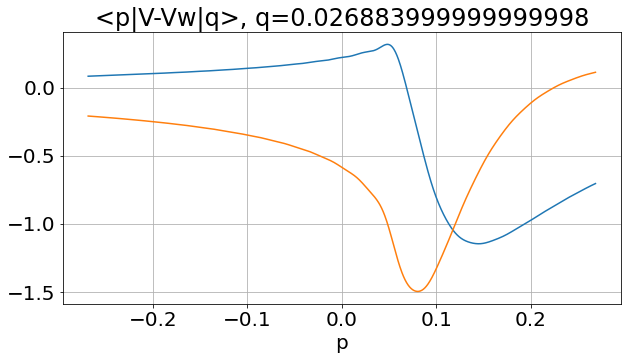

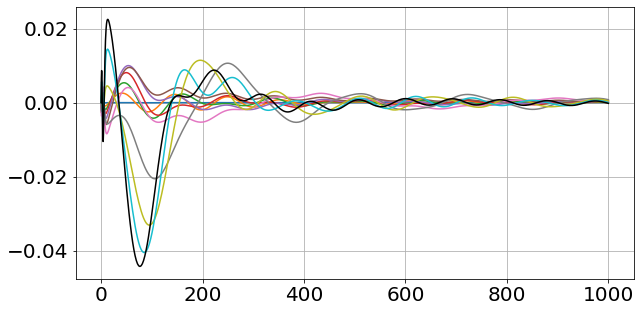

(0.010300274310755751+6.568058454904026e-06j)
(-0.008627557568219488-0.0056188929680208175j)


In [176]:
ks = np.linspace(-10*kwp, 10*kwp, num=1000)
zq = np.linspace(0, max(zp), num=int(1e5))
res = []
for k in ks:
    #res.append(np.trapz(EH.MCAk(-k, zq)*np.interp(zq, zp, I4)/EH.gamma(omega, kp, [k/EH.width]), zq))
    res.append(np.trapz(EH.MCAk(-k, zq)*np.interp(zq, zp, Iwp), zq))
    
fig, ax = plt.subplots(1,1, figsize=(10,5))
#plt.plot(zp, np.real(I4))
#plt.plot(zp, np.imag(I4))
plt.plot(ks, np.real(res))
plt.plot(ks, np.imag(res))
#plt.xlim([-0.1, 0.1])
#plt.ylim([-1e-3, 1e-3])
plt.xlabel('p')
plt.title(f'<p|V-Vw|q>, q={kwp}')
plt.grid()
plt.show()

z_new = zp.copy() #np.linspace(0, 3000, num=1000)
M1_new = np.zeros_like(z_new, dtype=np.complex_)
fig, ax = plt.subplots(1,1, figsize=(10,5))
for i in range(len(res)):
    M1_new += res[i]*EH.MCAk(ks[i], z_new)*(ks[1]-ks[0])
    if i%100==0:
        plt.plot(z_new, np.real(M1_new))
plt.plot(z_new, np.real(M1_new), 'k')
plt.grid()
plt.show()

print(np.trapz(EH.MD4(zp)*I4, zp))
print(np.trapz(np.conjugate(M1_new)*I4, zp))

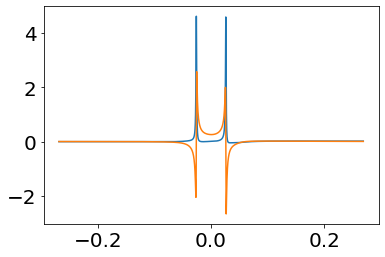

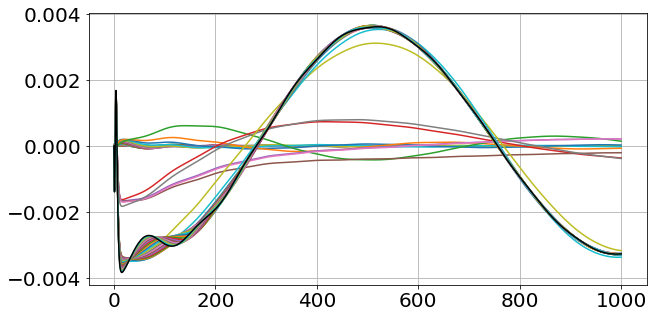

(0.010300274310755751+6.568058454904026e-06j)
(-0.00031571412886956544+0.00021974271474475856j)
(-0.0012898193132284182-0.002156551255855392j)
(-0.0014236480482503402+0.0007119957982384548j)
(-0.009973980884323858+0.017533104804222092j)
(0.009395733464452778-0.009346976082192508j)
(-0.008023131978805128+0.0151721674053151j)
(0.008258599220379553-0.010332077058076282j)
(-0.0005782474198710776+0.008186128722029586j)
(0.0006869761508044362-0.0013469564067526494j)
(0.00023546724157442502+0.004840090347238817j)
(0.0005183953136570108-0.0014205156257521942j)


In [186]:
ks = np.linspace(-10*kwp, 10*kwp, num=5000)
zq = np.linspace(0, max(zp), num=int(1e5))

res1, res2 = [], []
for k in ks:
    res1.append(np.trapz(EH.MCAk(-k, zq)*np.interp(zq, zp, I4)/EH.gamma(omega, kp, [k/EH.width]), zq))
    res2.append(np.trapz(EH.MCAk(-k, zq)*np.interp(zq, zp, Iwp)/EH.gamma(omega, kp, [k/EH.width]), zq))
    
const = np.trapz(res1,ks)/(1-np.trapz(res2,ks))

plt.plot(ks, np.real(np.array(res1)+const*np.array(res2)))
plt.plot(ks, np.imag(np.array(res1)+const*np.array(res2)))
plt.show()

z_new = zp.copy() #np.linspace(0, 3000, num=1000)
M1_new = np.zeros_like(z_new, dtype=np.complex_)
fig, ax = plt.subplots(1,1, figsize=(10,5))
for i in range(len(res1)):
    M1_new += (res1[i]+const*res2[i])*EH.MCAk(ks[i], z_new)*(ks[1]-ks[0])
    if i%100==0:
        plt.plot(z_new, np.real(M1_new))
plt.plot(z_new, np.real(M1_new), 'k')
plt.grid()
plt.show()

print(np.trapz(EH.MD4(zp)*I4, zp))
print(np.trapz(M1_new*I4, zp))

print(np.trapz(EH.MD4(zp)*I2, zp))
print(np.trapz(M1_new*I2, zp))

print(np.trapz(EH.MD4(zp)*Iwn, zp))
print(np.trapz(M1_new*Iwn, zp))

print(np.trapz(EH.MD4(zp)*Iwp, zp))
print(np.trapz(M1_new*Iwp, zp))

print(np.trapz((EH.MD4(zp)+M1_new)*Iwn, zp))
print(np.trapz((M1_new-const*EH.MCAk(kwp, zp))*Iwn, zp))

print(np.trapz((EH.MD4(zp)+M1_new)*Iwp, zp))
print(np.trapz((M1_new-const*EH.MCAk(kwp, zp))*Iwp, zp))

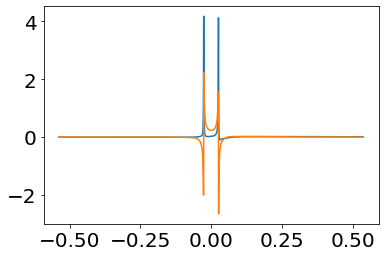

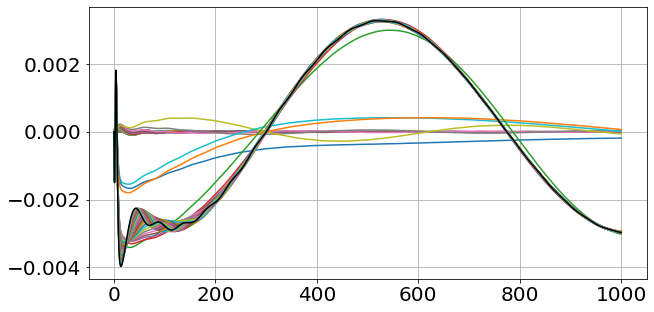

(0.010300274310755751+6.568058454904026e-06j)
(-0.00029946258107363817+0.00023008594216554306j)
(-0.0012898193132284182-0.002156551255855392j)
(-0.0013841949216532338+0.0007567296396905519j)
(-0.0015081786662926536+0.007930707628701537j)
(-0.00175207934250083+0.0008544613399494505j)
(-0.0007110360132178842+0.004695840652878787j)
(-0.0016380846243162013+0.0010608808507850795j)


In [178]:
knum = 3000
ks = np.hstack([np.linspace(-20*kwp, 0, num=knum), np.linspace(0, 20*kwp, num=knum)])

zq = np.linspace(0, max(zp), num=int(1e5))

res1, res2, res3 = [], [], []
for k in ks:
    res1.append(np.trapz(EH.MCAk(-k, zq)*np.interp(zq, zp, I4)/EH.gamma(omega, kp, [k/EH.width]), zq))
    res2.append(np.trapz(EH.MCAk(-k, zq)*np.interp(zq, zp, Iwn)/EH.gamma(omega, kp, [k/EH.width]), zq))
    res3.append(np.trapz(EH.MCAk(-k, zq)*np.interp(zq, zp, Iwp)/EH.gamma(omega, kp, [k/EH.width]), zq))
    
a11 = np.trapz(res1[:knum], ks[:knum])    
a12 = np.trapz(res2[:knum], ks[:knum])    
a13 = np.trapz(res3[:knum], ks[:knum])
a21 = np.trapz(res1[knum:], ks[knum:])    
a22 = np.trapz(res2[knum:], ks[knum:])    
a23 = np.trapz(res3[knum:], ks[knum:])      
cneg = (a11*(1-a23)+a21*a13)/((1-a12)*(1-a23)-a22*a13)
cpos = (a11*a22+a21*(1-a12))/((1-a12)*(1-a23)-a22*a13)

plt.plot(ks, np.real(np.array(res1)+cneg*np.array(res2)+cpos*np.array(res3)))
plt.plot(ks, np.imag(np.array(res1)+cneg*np.array(res2)+cpos*np.array(res3)))
plt.show()

z_new = zp.copy() #np.linspace(0, 3000, num=1000)
M1_new = np.zeros_like(z_new, dtype=np.complex_)
fig, ax = plt.subplots(1,1, figsize=(10,5))
for i in range(len(res1)):
    M1_new += (res1[i]+cneg*res2[i]+cpos*res3[i])*EH.MCAk(ks[i], z_new)*(ks[1]-ks[0])
    if i%100==0:
        plt.plot(z_new, np.real(M1_new))
plt.plot(z_new, np.real(M1_new), 'k')
plt.grid()
plt.show()

print(np.trapz(EH.MD4(zp)*I4, zp))
print(np.trapz(M1_new*I4, zp))

print(np.trapz(EH.MD4(zp)*I2, zp))
print(np.trapz(M1_new*I2, zp))

print(np.trapz((EH.MD4(zp)+M1_new)*Iwn, zp))
print(np.trapz((M1_new-cneg*EH.MCAk(kwn,zp)-cpos*EH.MCAk(kwp,zp))*Iwn, zp))

print(np.trapz((EH.MD4(zp)+M1_new)*Iwp, zp))
print(np.trapz((M1_new-cneg*EH.MCAk(kwn,zp)-cpos*EH.MCAk(kwp,zp))*Iwp, zp))

In [181]:
print(abs(-4.99670275551862+2.1191244137667113j))
abs(-2.9534521752809773+1.2435787233348983j)

print(abs((-0.0015081786662926536+0.007930707628701537j)/(-0.00175207934250083+0.0008544613399494505j)))
abs((-0.0007110360132178842+0.004695840652878787j)/(-0.0016380846243162013+0.0010608808507850795j))

5.4274972784912086


3.204585432283432

In [189]:
print(const)
print(cneg+cpos)

(0.020166782820804034+0.009792051172476536j)
(0.021550342355947938+0.009292292542719856j)


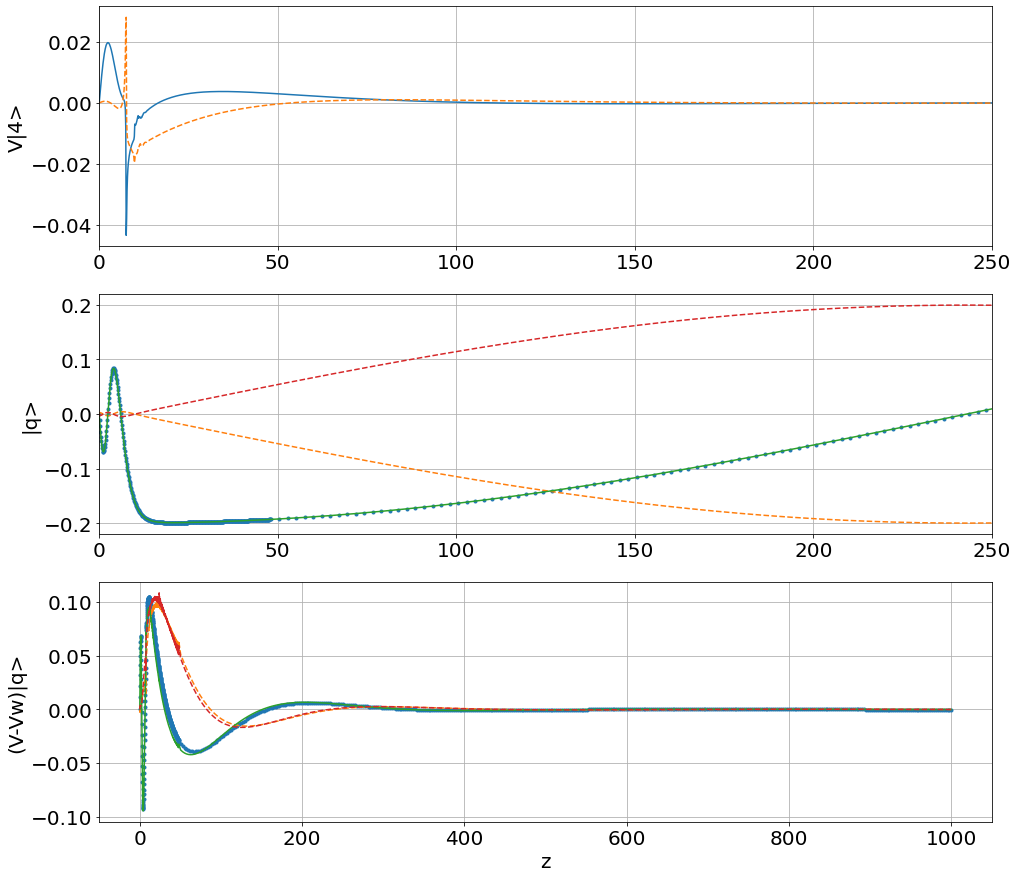

In [102]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(3,1, figsize=(16,15))
ax[0].plot(zp, (2.24105364)*np.real(I4))
ax[0].plot(zp, (2.24105364)*np.imag(I4), '--')
ax[0].grid()
ax[0].set_ylabel('V|4>')
ax[0].set_xlim([0,250])

ax[1].plot(zp, np.real(EH.MCAk(kwp, zp)), '.')
ax[1].plot(zp, np.imag(EH.MCAk(kwp, zp)), '--')
ax[1].plot(zp, np.real(EH.MCAk(-kwp, zp)))
ax[1].plot(zp, np.imag(EH.MCAk(-kwp, zp)), '--')
ax[1].grid()
ax[1].set_ylabel('|q>')
ax[1].set_xlim([0,250])

ax[2].plot(zp, np.real(Iwp), '.')
ax[2].plot(zp, np.imag(Iwp), '--')
ax[2].plot(zp, np.real(Iwn))
ax[2].plot(zp, np.imag(Iwn), '--')
ax[2].grid()
ax[2].set_ylabel('(V-Vw)|q>')
#ax[2].set_xlim([0,250])

# wq = -omega/np.sqrt(2)/(kwp/EH.width)*plasma_dispersion_func(omega/np.sqrt(2)/(kwp/EH.width)) * EH.MCAk(kwp, zp)
# ax[3].plot(zp, np.real(wq), label='Re[Vw|q>]')
# ax[3].plot(zp, np.imag(wq), '--', label='Im[Vw|q>]')
# ax[3].plot(zp, np.real(Iwp+wq), label='Re[V|q>]')
# ax[3].plot(zp, np.imag(Iwp+wq), '--', label='Re[V|q>]')
# ax[3].grid()
# ax[3].legend()
# ax[3].set_ylabel('Vw|q>')

plt.xlabel('z')
plt.show()

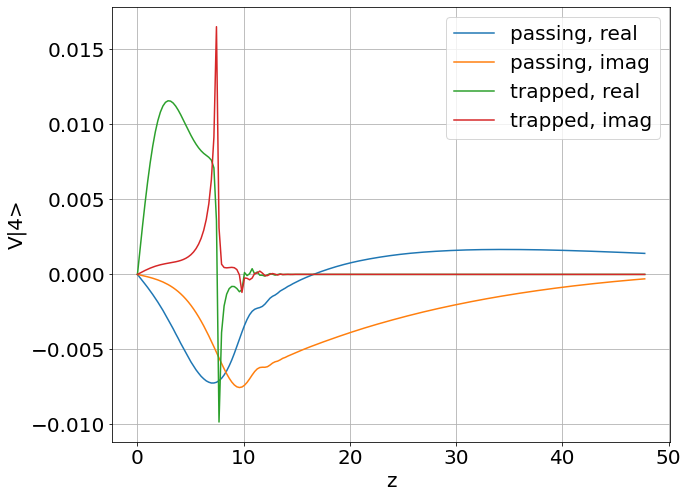

In [194]:
#zp = np.hstack([np.linspace(0, EH.hole_region, num=200, endpoint=False), np.linspace(EH.hole_region, 100, num=100)])
zp = np.linspace(0, EH.hole_region, num=200, endpoint=False)

tau_spline_passing, warray = EH.logtau_passing(lgwmin=1, lgwmax=9, lgwnum=9, wmin=1e-4, wmax=8, wnum=6000, znum=2000)

tau_spline_trapped, wmax = EH.logtau_trapped(wnum=5000, znum=6000)


I4 = np.array([EH.orbit_integral_passing_discrete(z0=z0i, omega=omega, tau_spline_passing=tau_spline_passing,
          warray=warray, func='MD4', k=None, wnum=600, lgvzmin=-15, znum=200) for z0i in zp])

fig, ax = plt.subplots(1,1, figsize=(10,8))
plt.plot(zp, np.real(I4), label='passing, real')
plt.plot(zp, np.imag(I4), label='passing, imag')

I4 = np.array([EH.orbit_integral_trapped(z0=z0i, omega=omega, tau_spline_trapped=tau_spline_trapped,
          wmax=wmax, func='MD4', k=None, lgvzmin=-15, wnum=600, zmaxmin=1e-9, zturn=1e-2, znum=200) for z0i in zp])

plt.plot(zp, np.real(I4), label='trapped, real')
plt.plot(zp, np.imag(I4), label='trapped, imag')
plt.ylabel('V|4>')
plt.xlabel('z')
plt.legend()
plt.grid()
plt.show()

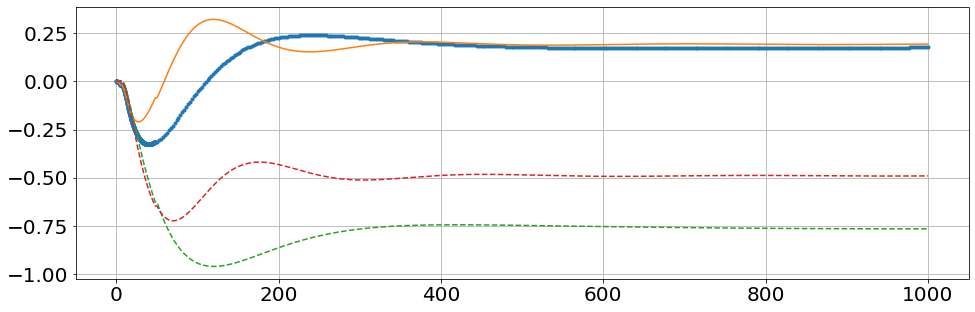

In [103]:
res1, res2 = [], []

for i in range(len(zp)):
    
    res1.append(np.trapz(EH.MCAk(-kwp, zp[:i])* Iwp[:i], zp[:i]))
    res2.append(np.trapz(EH.MCAk(kwp, zp[:i])* Iwn[:i], zp[:i]))

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1,1, figsize=(16,5))
plt.plot(zp, np.real(res1), '.')
plt.plot(zp, np.real(res2))
plt.plot(zp, np.imag(res1), '--')
plt.plot(zp, np.imag(res2), '--')
#plt.xlim([0, 250])
plt.grid()
plt.show()

(3.270491735436533+5.321988241920048j)
(0.12510787958386835-0.3592969488249884j)


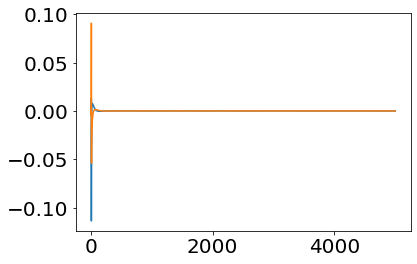

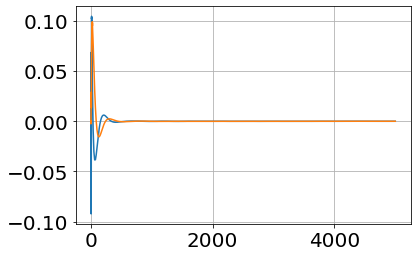

(0.2946040311552797+0.06457396813544668j)


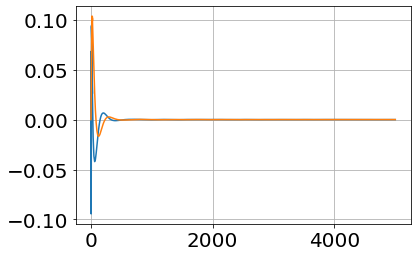

(0.35196206407056385+0.046991753635594706j)


In [1493]:
r1 = (np.trapz(EH.dpdz(zp)*I4, zp)) / (np.trapz(M1*I4, zp))
print(r1)

I2 = np.array([EH.orbit_integral_passing_discrete(z0=zi, omega=omega, tau_spline_passing=tau_spline_passing,
          warray=warray, func='MD2', wnum=600, lgvzmin=-15, znum=200) for zi in zp])

I2 += np.array([EH.orbit_integral_trapped(z0=zi, omega=omega, tau_spline_trapped=tau_spline_trapped,
          wmax=wmax, func='MD2', lgvzmin=-15, wnum=400, zmaxmin=1e-9, zturn=1e-2, znum=200) for zi in zp])

r2 = np.trapz(EH.dpdz(zp)*I2, zp) / np.trapz(M1*I2, zp)
print(r2)

plt.plot(zp, np.real(I2))
plt.plot(zp, np.imag(I2))
#plt.xlim([0, 250])
plt.show()

kwp = kp * EH.width * np.real(omega)

Iwp = np.array([EH.orbit_integral_passing_continuous(z0=zi, omega=omega, k=kwp, tau_spline_passing=tau_spline_passing, 
                                           warray=warray, wnum=600, lgvzmin=-15, znum=200) for zi in zp])

Iwp += np.array([EH.orbit_integral_trapped(z0=zi, omega=omega, tau_spline_trapped=tau_spline_trapped,
          wmax=wmax, func='MCAk', k=kwp, lgvzmin=-15, wnum=400, zmaxmin=1e-9, zturn=1e-2, znum=200) for zi in zp])

plt.plot(zp, np.real(Iwp))
plt.plot(zp, np.imag(Iwp))
# plt.plot(zp, np.real(M1))
# plt.plot(zp, np.imag(M1))
#plt.xlim([0, 200])
plt.grid()
plt.show()

r3 = np.trapz(EH.dpdz(zp)*Iwp, zp) / np.trapz(M1*Iwp, zp)
print(r3)


kwn = - kwp

Iwn = np.array([EH.orbit_integral_passing_continuous(z0=zi, omega=omega, k=kwn, tau_spline_passing=tau_spline_passing, 
                                           warray=warray, wnum=600, lgvzmin=-15, znum=200) for zi in zp])

Iwn += np.array([EH.orbit_integral_trapped(z0=zi, omega=omega, tau_spline_trapped=tau_spline_trapped,
          wmax=wmax, func='MCAk', k=kwn, lgvzmin=-15, wnum=400, zmaxmin=1e-9, zturn=1e-2, znum=200) for zi in zp])

plt.plot(zp, np.real(Iwn))
plt.plot(zp, np.imag(Iwn))
plt.grid()
plt.show()

r4 = np.trapz(EH.dpdz(zp)*Iwn, zp) / np.trapz(M1*Iwn, zp)
print(r4)